In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os


######################################################################################################### 
####                                            Arguments                                           #####
######################################################################################################### 

## account for the folder structure 
import sys
sys.path.append(os.path.abspath("../scr"))


import wandb 

In [6]:
# Replace argparse with a dictionary
args = {

    "seed": 42, 

    'dataset_transform': [],  # Example list of transformations
    'numbers_list': [1,2,3,4,5,6],  #  [7,9],  # List of integers for class selection
    'N': 100,  # Number of distinct training images per class
    'supervision_label_val': 10,  # An integer value for supervision

    # -----graph-----
    'num_internal_nodes': 1000,  # Number of internal nodes
    'graph_type': 'custom_two_branch',  # custom_two_branch 'fully_connected'  stochastic_block fully_connected_w_self  |  Type of graph fully_connected 'stochastic_block_hierarchy'

    'remove_sens_2_sens': False, 
    'remove_sens_2_sup': False, 

    # -----model-----
    "use_bias": True,
    "normalize_msg": False, 
    'model_type': 'IPC',  # Predictive model type; IPC, PC
    'weight_init': 'fixed 0.001',  # Weight initialization
    # 'weight_init': 'normal 0.001',  # Weight initialization
    'T': 5,  # Number of iterations for gradient descent
    'lr_values': 0.1,  # Learning rate for values
    'lr_weights': 0.0001,  # Learning rate for weights
    # 'lr_weights': 0.0005,  # Learning rate for weights
    'activation_func': 'swish',  # Activation function

    # -----learning-----
    'epochs': 10,  # Number of epochs
    'batch_size': 1,  # Batch size
    'seed': 42,  # Random seed
    'optimizer': False,  # Optimizer, can be True with a float value

    # -----logging-----
    'use_wandb': 'disabled',  # Wandb mode
}

# Access the arguments just like you would with argparse
print(args['dataset_transform'])  # Example of accessing an argument

class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)


# Create an object from the dictionary
args = Args(**args)



[]


In [7]:



# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"
    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"], 
        # "params_general": {
        #     "remove_sens_2_sens": args.remove_sens_2_sens,  # Set from command line
        #     "remove_sens_2_sup": args.remove_sens_2_sup,    # Set from command line
        #     },
        },  
    "seed": args.seed,   
}

print("zzz", args.remove_sens_2_sens, args.remove_sens_2_sup)
graph_params["graph_type"]["params"]["remove_sens_2_sens"] = args.remove_sens_2_sens  
graph_params["graph_type"]["params"]["remove_sens_2_sup"]  = args.remove_sens_2_sup 


if graph_params["graph_type"]["name"] == "stochastic_block":
    
    # override internal nodes if doing clustering
    graph_params["internal_nodes"] = (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

if graph_params["graph_type"]["name"] == "stochastic_block_hierarchy":
    # Configure internal nodes for stochastic_block_hierarchy
    # Define the hierarchical structure with two layers and a final layer
    layer_1_clusters = 49  # First layer has 49 clusters (7x7 grid of 4x4 blocks)
    clusters_per_layer = layer_1_clusters
    num_layers = 2  # Only two layers before the final layer
    final_layer_clusters = 10  # Number of clusters in the final layer

    # Calculate the total internal nodes across the layers
    # - `clusters_per_layer * 16` accounts for the 4x4 nodes per cluster in each layer
    # - The final layer has `final_layer_clusters` nodes
    graph_params["internal_nodes"] = (clusters_per_layer * 16 * num_layers) + final_layer_clusters


Using device: cuda
Seed used 42
Device name:  NVIDIA GeForce MX130
zzz False False


In [54]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj

class GraphBuilder:
    def __init__(self, sensory_nodes, internal_nodes, supervision_nodes, seed=None):
        self.sensory_nodes = sensory_nodes
        self.internal_nodes = internal_nodes
        self.supervision_nodes = supervision_nodes
        self.total_nodes = sensory_nodes + internal_nodes + supervision_nodes
        self.edge_index = []
        self.edge_type = []
        
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
            random.seed(seed)
        
        # Build both branches
        self.build_branch_1()
        self.build_branch_2()

        # Convert edge_index to tensor after graph construction
        self.edge_index = torch.tensor(self.edge_index, dtype=torch.long).t().contiguous()

    def build_branch_1(self):
        """Builds Branch 1: Sensory -> Internal L1 -> Internal L2 -> Supervision."""
        # Define clusters for each internal layer in Branch 1
        internal_layers = self.create_internal_layers(num_layers=2, clusters_per_layer=5, cluster_size=16, start_idx=self.sensory_nodes)
        
        # Step 1: Sensory -> Internal Layer 1 (sparse)
        self.connect_clusters(range(self.sensory_nodes), internal_layers[0], edge_type="Sens2Inter", dense=False)
        
        # Step 2: Internal Layer 1 -> Internal Layer 2 (sparse)
        self.connect_clusters(internal_layers[0], internal_layers[1], edge_type="Inter2Inter", dense=False)
        
        # Step 3: Internal Layer 2 -> Supervision (sparse)
        supervision_indices = range(self.total_nodes - self.supervision_nodes, self.total_nodes)
        self.connect_clusters(internal_layers[1], supervision_indices, edge_type="Inter2Sup", dense=False)

    def build_branch_2(self):
        """Builds Branch 2: Supervision -> Internal L3 -> Internal L4 -> Sensory."""
        # Define clusters for each internal layer in Branch 2
        start_idx = self.sensory_nodes + (2 * 5 * 16)  # Offset by the internal nodes used in Branch 1
        internal_layers = self.create_internal_layers(num_layers=2, clusters_per_layer=5, cluster_size=16, start_idx=start_idx)
        
        # Step 1: Supervision -> Internal Layer 3 (sparse)
        supervision_indices = range(self.total_nodes - self.supervision_nodes, self.total_nodes)
        self.connect_clusters(supervision_indices, internal_layers[0], edge_type="Sup2Inter", dense=False)
        
        # Step 2: Internal Layer 3 -> Internal Layer 4 (sparse)
        self.connect_clusters(internal_layers[0], internal_layers[1], edge_type="Inter2Inter", dense=False)
        
        # Step 3: Internal Layer 4 -> Sensory (sparse)
        self.connect_clusters(internal_layers[1], range(self.sensory_nodes), edge_type="Inter2Sens", dense=False)

    def create_internal_layers(self, num_layers, clusters_per_layer, cluster_size, start_idx):
        """Creates layers of internal nodes organized into clusters for either branch."""
        layers = []
        for _ in range(num_layers):
            layer_clusters = []
            for _ in range(clusters_per_layer):
                cluster = list(range(start_idx, start_idx + cluster_size))
                layer_clusters.append(cluster)
                start_idx += cluster_size
            layers.append(layer_clusters)
        return layers

    def connect_clusters(self, source_nodes, target_clusters, edge_type, dense=False):
        """
        Connects clusters in dense or sparse configurations, ensuring that edges are added as pairs of individual nodes.
        Handles cases where source_nodes or target_clusters is a list of individual nodes or a list of clusters.
        """
        # Flatten source_nodes if it contains clusters
        if isinstance(source_nodes, range) or isinstance(source_nodes[0], int):
            source_nodes = list(source_nodes)
        else:
            source_nodes = [node for cluster in source_nodes for node in cluster]

        # If target_clusters is a list of individual nodes, wrap it in another list to make it consistent
        if isinstance(target_clusters, range) or isinstance(target_clusters[0], int):
            target_clusters = [list(target_clusters)]
        
        for source in source_nodes:
            # Flatten target clusters into a list of individual nodes
            target_list = [node for cluster in target_clusters for node in cluster]
            
            if dense:
                for target in target_list:
                    if source != target:
                        self.edge_index.append([source, target])
                        self.edge_type.append(edge_type)
            else:
                # Sparse connections: randomly select 10% of the target nodes
                sparse_targets = np.random.choice(target_list, size=int(0.1 * len(target_list)), replace=False)
                for target in sparse_targets:
                    self.edge_index.append([source, target])
                    self.edge_type.append(edge_type)
        
        # Intra-cluster dense connections for each layer in target_clusters
        for cluster in target_clusters:
            for i in range(len(cluster)):
                for j in range(i + 1, len(cluster)):
                    self.edge_index.append([cluster[i], cluster[j]])
                    self.edge_index.append([cluster[j], cluster[i]])
                    self.edge_type.append("Inter2Inter")
                    self.edge_type.append("Inter2Inter")

# Parameters for the graph
sensory_nodes = 100  # 28x28 grid for MNIST images
internal_nodes = 640  # 4 layers * 5 clusters * 16 nodes per cluster
supervision_nodes = 10

# Instantiate and build the graph
graph_builder = GraphBuilder(sensory_nodes=sensory_nodes, internal_nodes=internal_nodes, supervision_nodes=supervision_nodes, seed=42)

# Use to_dense_adj to create and plot the adjacency matrix
adj_matrix = to_dense_adj(graph_builder.edge_index, max_num_nodes=graph_builder.total_nodes).squeeze(0)

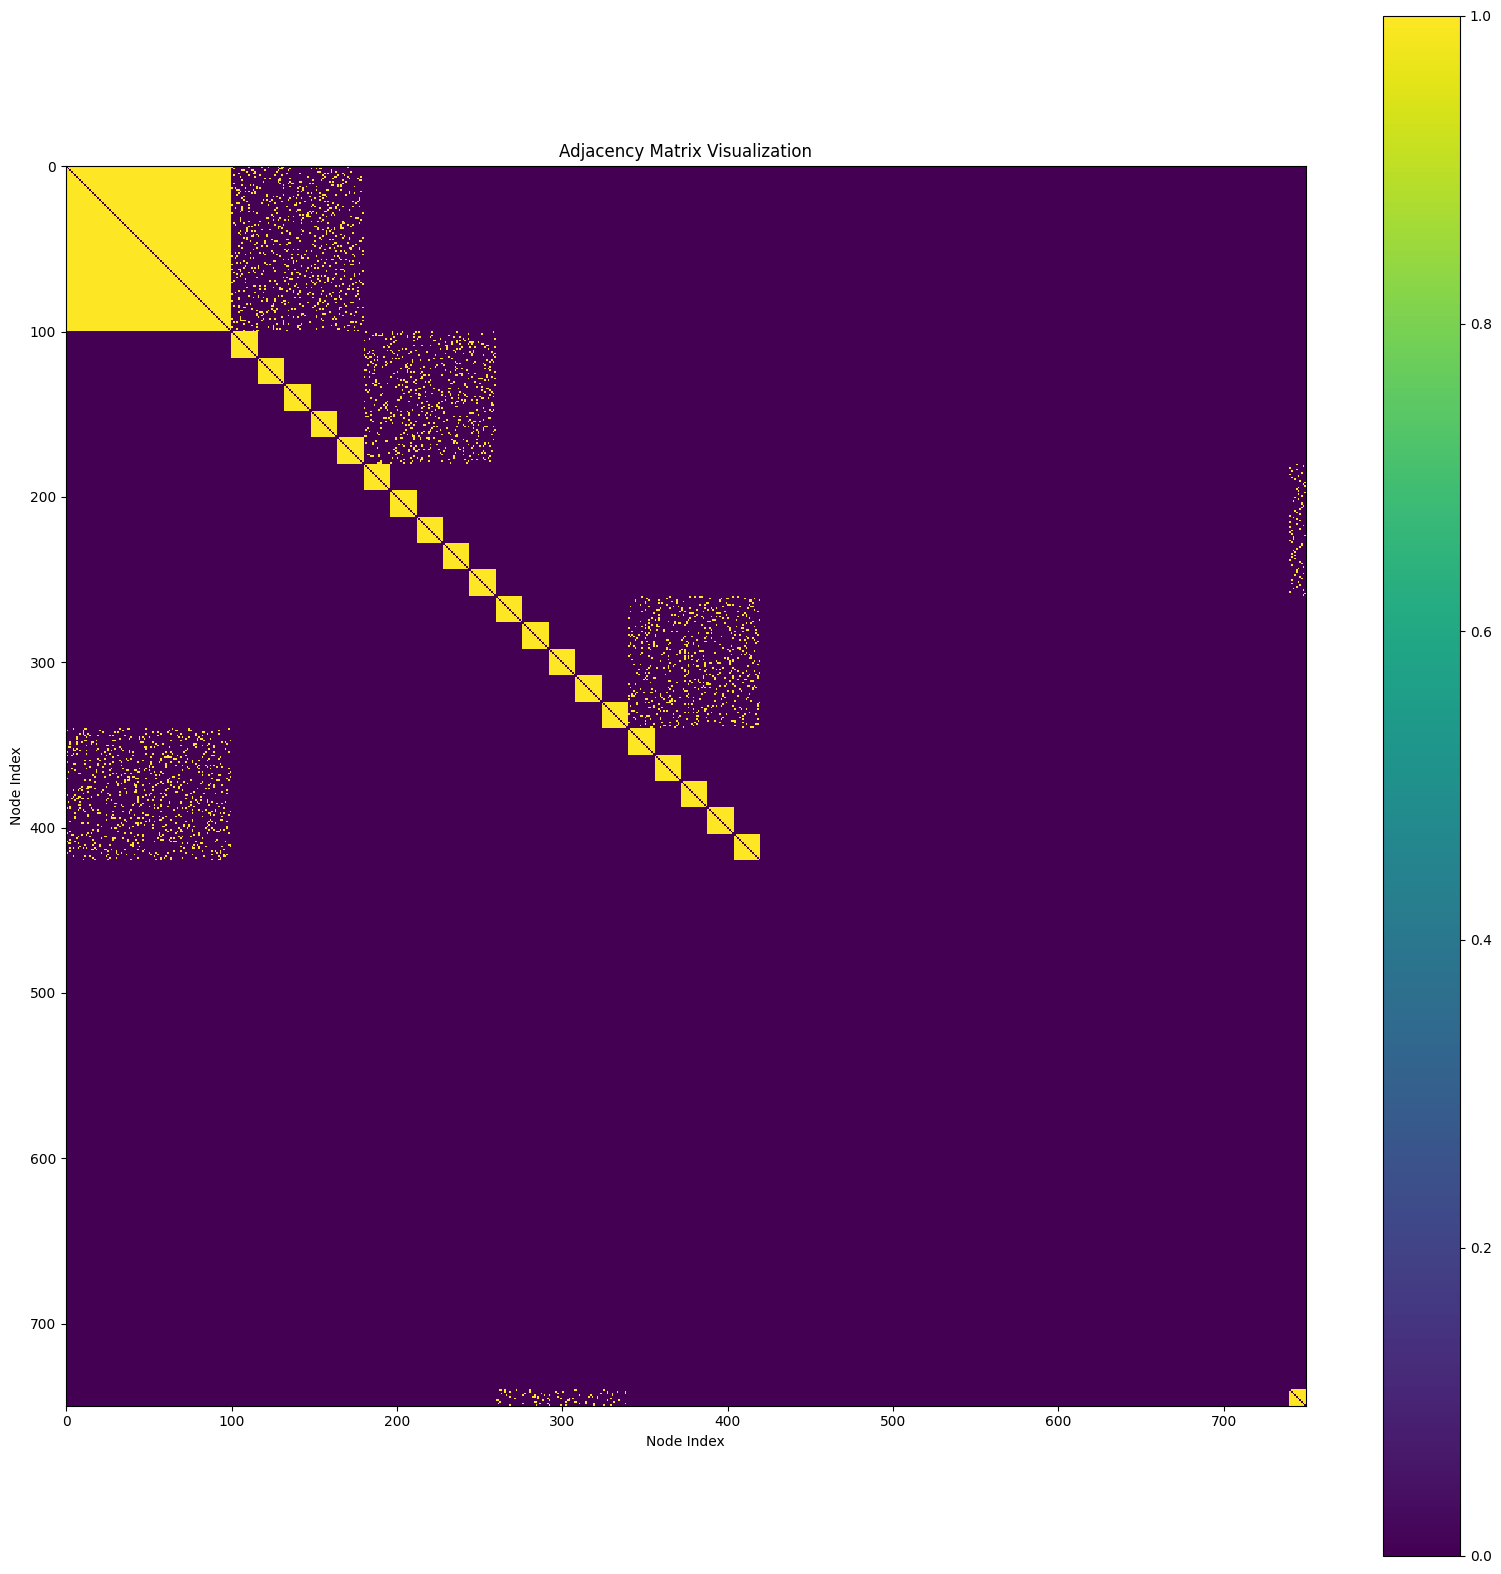

In [55]:
# Plot the adjacency matrix
plt.figure(figsize=(20, 20))
plt.imshow(adj_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Adjacency Matrix Visualization")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

In [56]:
# Print out the indices for each part of the graph for verification
print("Sensory Node Indices:", graph_builder.sensory_indices)
print("Branch 1 Internal Node Indices:", graph_builder.branch1_internal_indices)
print("Branch 2 Internal Node Indices:", graph_builder.branch2_internal_indices)
print("Supervision Node Indices:", graph_builder.supervision_indices)

# Use to_dense_adj to create and plot the adjacency matrix
adj_matrix = to_dense_adj(graph_builder.edge_index, max_num_nodes=graph_builder.total_nodes).squeeze(0)

# Plot the adjacency matrix
plt.figure(figsize=(10, 10))
plt.imshow(adj_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.title("Adjacency Matrix Visualization")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

AttributeError: 'GraphBuilder' object has no attribute 'sensory_indices'

In [16]:
# Retry the tensor conversion and visualization with confirmation steps
try:
    # Convert edge_index to tensor with explicit handling
    edge_index = torch.tensor([list(edge) for edge in graph_builder.edge_index], dtype=torch.long).t().contiguous()
    edge_type_map = {"Sens2Sens": 0, "Sens2Inter": 1, "Sens2Sup": 2, "Inter2Sens": 3, 
                     "Inter2Inter": 4, "Inter2Sup": 5, "Sup2Sens": 6, "Sup2Inter": 7, "Sup2Sup": 8}
    edge_type = torch.tensor([edge_type_map[etype] for etype in graph_builder.edge_type], dtype=torch.long)

    # Create and visualize the weight matrix (adjacency matrix)
    weight_matrix = torch.zeros(graph_builder.total_nodes, graph_builder.total_nodes)
    for i, (src, dst) in enumerate(edge_index.t()):
        weight_matrix[src, dst] = 1  # Assign a weight of 1 for each edge

    # Display the weight matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(weight_matrix, cmap="viridis", interpolation="nearest")
    plt.colorbar()
    plt.title("Weight Matrix Visualization")
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.show()

except Exception as e:
    print("An error occurred:", e)


An error occurred: 'list' object cannot be interpreted as an integer


In [5]:



# Using argparse values
torch.manual_seed(args.seed)

generator_seed = torch.Generator()
generator_seed.manual_seed(args.seed)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Seed used", args.seed)
if torch.cuda.is_available():
    print("Device name: ", torch.cuda.get_device_name(0))


import torchvision.transforms as transforms
import numpy as np


transform_list = [
    transforms.ToTensor()
]

if args.dataset_transform:

    if "normalize_min1_plus1" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.5,), (0.5,)))

    if "normalize_mnist_mean_std" in args.dataset_transform:
        transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))
    
    if "random_rotation" in args.dataset_transform:
        transform_list.append(transforms.RandomRotation(degrees=20))
    

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######################################################################################################### 
####                                            Dataset                                             #####
######################################################################################################### 


## Subset of the dataset (for faster development)
# subset_size = 100  # Number of samples to use from the training set
# indices = list(range(len(mnist_trainset)))
# random.shuffle(indices)
# subset_indices = indices[:subset_size]

# mnist_train_subset = torch.utils.data.Subset(mnist_trainset, subset_indices)
# print("USSSSSING SUBSEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEET")

# CustomGraphDataset params
dataset_params = {
    "mnist_dataset":            mnist_trainset,
    # "mnist_dataset":            mnist_train_subset,
    "supervised_learning":      True,
    "numbers_list":             args.numbers_list,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "N":                        args.N,     # taking the first n instances of each digit or use "all"
    "edge_index":               None,
    "supervision_label_val":    args.supervision_label_val,         # Strength of label signal within the graph. MNIST ~0-1, label_vector[label] = self.supervision_label_val
} 

from graphbuilder import graph_type_options

# Define the graph type
# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": args.num_internal_nodes,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": {    
        "name": args.graph_type, # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
        "params": graph_type_options[args.graph_type]["params"], 
        # "params_general": {
        #     "remove_sens_2_sens": args.remove_sens_2_sens,  # Set from command line
        #     "remove_sens_2_sup": args.remove_sens_2_sup,    # Set from command line
        #     },
        },  
    "seed": args.seed,   
}

print("zzz", args.remove_sens_2_sens, args.remove_sens_2_sup)
graph_params["graph_type"]["params"]["remove_sens_2_sens"] = args.remove_sens_2_sens  
graph_params["graph_type"]["params"]["remove_sens_2_sup"]  = args.remove_sens_2_sup 


if graph_params["graph_type"]["name"] == "stochastic_block":
    
    # override internal nodes if doing clustering
    graph_params["internal_nodes"] = (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

if graph_params["graph_type"]["name"] == "stochastic_block_hierarchy":
    # Configure internal nodes for stochastic_block_hierarchy
    # Define the hierarchical structure with two layers and a final layer
    layer_1_clusters = 49  # First layer has 49 clusters (7x7 grid of 4x4 blocks)
    clusters_per_layer = layer_1_clusters
    num_layers = 2  # Only two layers before the final layer
    final_layer_clusters = 10  # Number of clusters in the final layer

    # Calculate the total internal nodes across the layers
    # - `clusters_per_layer * 16` accounts for the 4x4 nodes per cluster in each layer
    # - The final layer has `final_layer_clusters` nodes
    graph_params["internal_nodes"] = (clusters_per_layer * 16 * num_layers) + final_layer_clusters

from dataset import CustomGraphDataset

# Initialize the GraphBuilder
custom_dataset_train = CustomGraphDataset(graph_params, **dataset_params)


dataset_params["batch_size"] = args.batch_size
dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

print("Device \t\t\t:", device)
print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


from helper.plot import plot_adj_matrix

single_graph = custom_dataset_train.edge_index


print("--------------Init DataLoader --------------------")
train_loader = DataLoader(custom_dataset_train, 
                          batch_size=dataset_params["batch_size"], 
                          shuffle=True, 
                          generator=generator_seed,
                          num_workers=1
                          )




NUM_SENSORY = 28*28  # 10

## TODO: FIX HOW TO DO THIS 
#### ---------------------------------------------------------------------------------------------------------------
# sensory_indices    = range(NUM_SENSORY)
# internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
# num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
# supervision_indices = None

# if dataset_params["supervised_learning"]:
#     label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
#     supervision_indices = label_indices
#     num_vertices += 10

# print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
# print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
# print("num_vertices \t\t:", num_vertices)

# if dataset_params["supervised_learning"]:
#   assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
# else:
#   assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"
#### ---------------------------------------------------------------------------------------------------------------

num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices



print(train_loader.batch_size)
for batch, clean_image in train_loader:
    
    values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
    x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
    print("edge_index", edge_index.shape)

    print(batch.x[:, 0].shape)
    print(custom_dataset_train.edge_index.shape)
    

    full_batch = edge_index

    break




######################################################################################################### 
####                                            VALIDATION                                          #####
######################################################################################################### 
 
# from helper.validate_MP import validate_messagePassing
# validate_messagePassing()

######################################################################################################### 
####                                            FIND OPTIMAL LR                                     #####
######################################################################################################### 
""" 
SKIPPING FOR NOW, see local  
"""



######################################################################################################### 
####                                              Model  (setup)                                    #####
######################################################################################################### 

# lr_gamma, lr_alpha =  (0.1 ,  0.0001)
# lr_gamma, lr_alpha =  (0.1, 0.00001)


model_params = {
    
    'num_vertices': num_vertices,
    'sensory_indices': (sensory_indices), 
    'internal_indices': (internal_indices), 
    "supervised_learning": (supervision_indices),

    "lr_params": (args.lr_values, args.lr_weights),
    #   (args.lr_gamma, args.lr_alpha), 
    "T": args.T,
    "graph_structure": custom_dataset_train.edge_index_tensor, 
    "batch_size": train_loader.batch_size, 
    'edge_type': custom_dataset_train.edge_type, 
    "use_bias": args.use_bias,
 
    "use_learning_optimizer": args.optimizer if not args.optimizer  else [args.optimizer],    # False or [0], [(weight_decay=)]
    
    # "weight_init": "uniform",   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "weight_init": args.weight_init,   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
    "activation": args.activation_func,  
    "clamping": None , # (0, torch.inf) or 'None' 

    "normalize_msg": args.normalize_msg,
 }

# 

learning_params = model_params.copy()
learning_params['sensory_indices'] = list(learning_params['sensory_indices'])
learning_params['internal_indices'] = list(learning_params['internal_indices'])
learning_params['supervised_learning'] = list(learning_params['supervised_learning'])
# learning_params['transform'] = transform.to_dict()["transform"]
learning_params['dataset_transform'] = args.dataset_transform

learning_params['graph_structure'] = (learning_params['graph_structure']).cpu().numpy().tolist()

model_params_name = f"num_internal_nodes_{args.num_internal_nodes}_T_{args.T}_lr_weights_{args.lr_weights}_lr_values_{args.lr_values}_batch_size_{train_loader.batch_size}"

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    
    raise TypeError('Unknown type:', type(obj))

# combi of learning params and dataset params
params_dict = {**dataset_params, **learning_params}


import json

from datetime import datetime




save_model_params = False

GRAPH_TYPE = graph_params["graph_type"]["name"]    #"fully_connected"
# GRAPH_TYPE = "test"    #"fully_connected"

date_hour = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

model_dir = f"trained_models/test/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"
# model_dir = f"trained_models/{args.model_type.lower()}/{GRAPH_TYPE}/{model_params_name}_{date_hour}/"

# Define the directory path
print("Saving model, params, graph_structure to :", model_dir)

# Ensure the directory exists
os.makedirs(model_dir, exist_ok=True)

# For saving, validation, re-creation 
os.makedirs(os.path.join(model_dir, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "parameter_info"), exist_ok=True)

# For testing the model
os.makedirs(os.path.join(model_dir, "eval"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/generation"), exist_ok=True)
# os.makedirs(os.path.join(model_dir, "reconstruction"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/classification"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/denoise"), exist_ok=True)
os.makedirs(os.path.join(model_dir, "eval/occlusion"), exist_ok=True)

# Monitor during training
os.makedirs(os.path.join(model_dir, "energy"), exist_ok=True)

plot_adj_matrix(single_graph, model_dir, 
                node_types=(sensory_indices, internal_indices, supervision_indices))
plot_adj_matrix(full_batch, model_dir, node_types=None)





Using device: cuda
Seed used 42
Device name:  NVIDIA GeForce MX130
zzz False False
Supervised learning
Taking first n=100 digits from each class
graph_params {'internal_nodes': 1000, 'supervised_learning': True, 'graph_type': {'name': 'fully_connected', 'params': {'remove_sens_2_sens': False, 'remove_sens_2_sup': False}}, 'seed': 42}
Setting seed: 42
--------Init base indices for sensory, internal, supervision nodes--------
--------Updating base indices for sensory, internal, supervision nodes--------
{'remove_sens_2_sens': False, 'remove_sens_2_sup': False}
Creating graph structure for fully_connected
graph created
self.edge_index torch.Size([2, 3216642])
---------save_graph_to_file--------------------
Graph data saved in graphs/fully_connected/_normal/42
-----Done-----
1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55

In [6]:
num_vertices = custom_dataset_train.num_vertices
sensory_indices = custom_dataset_train.sensory_indices
internal_indices = custom_dataset_train.internal_indices
supervision_indices = custom_dataset_train.supervision_indices

print(num_vertices)
print(sensory_indices)  
print(internal_indices)
print(supervision_indices)

1794
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

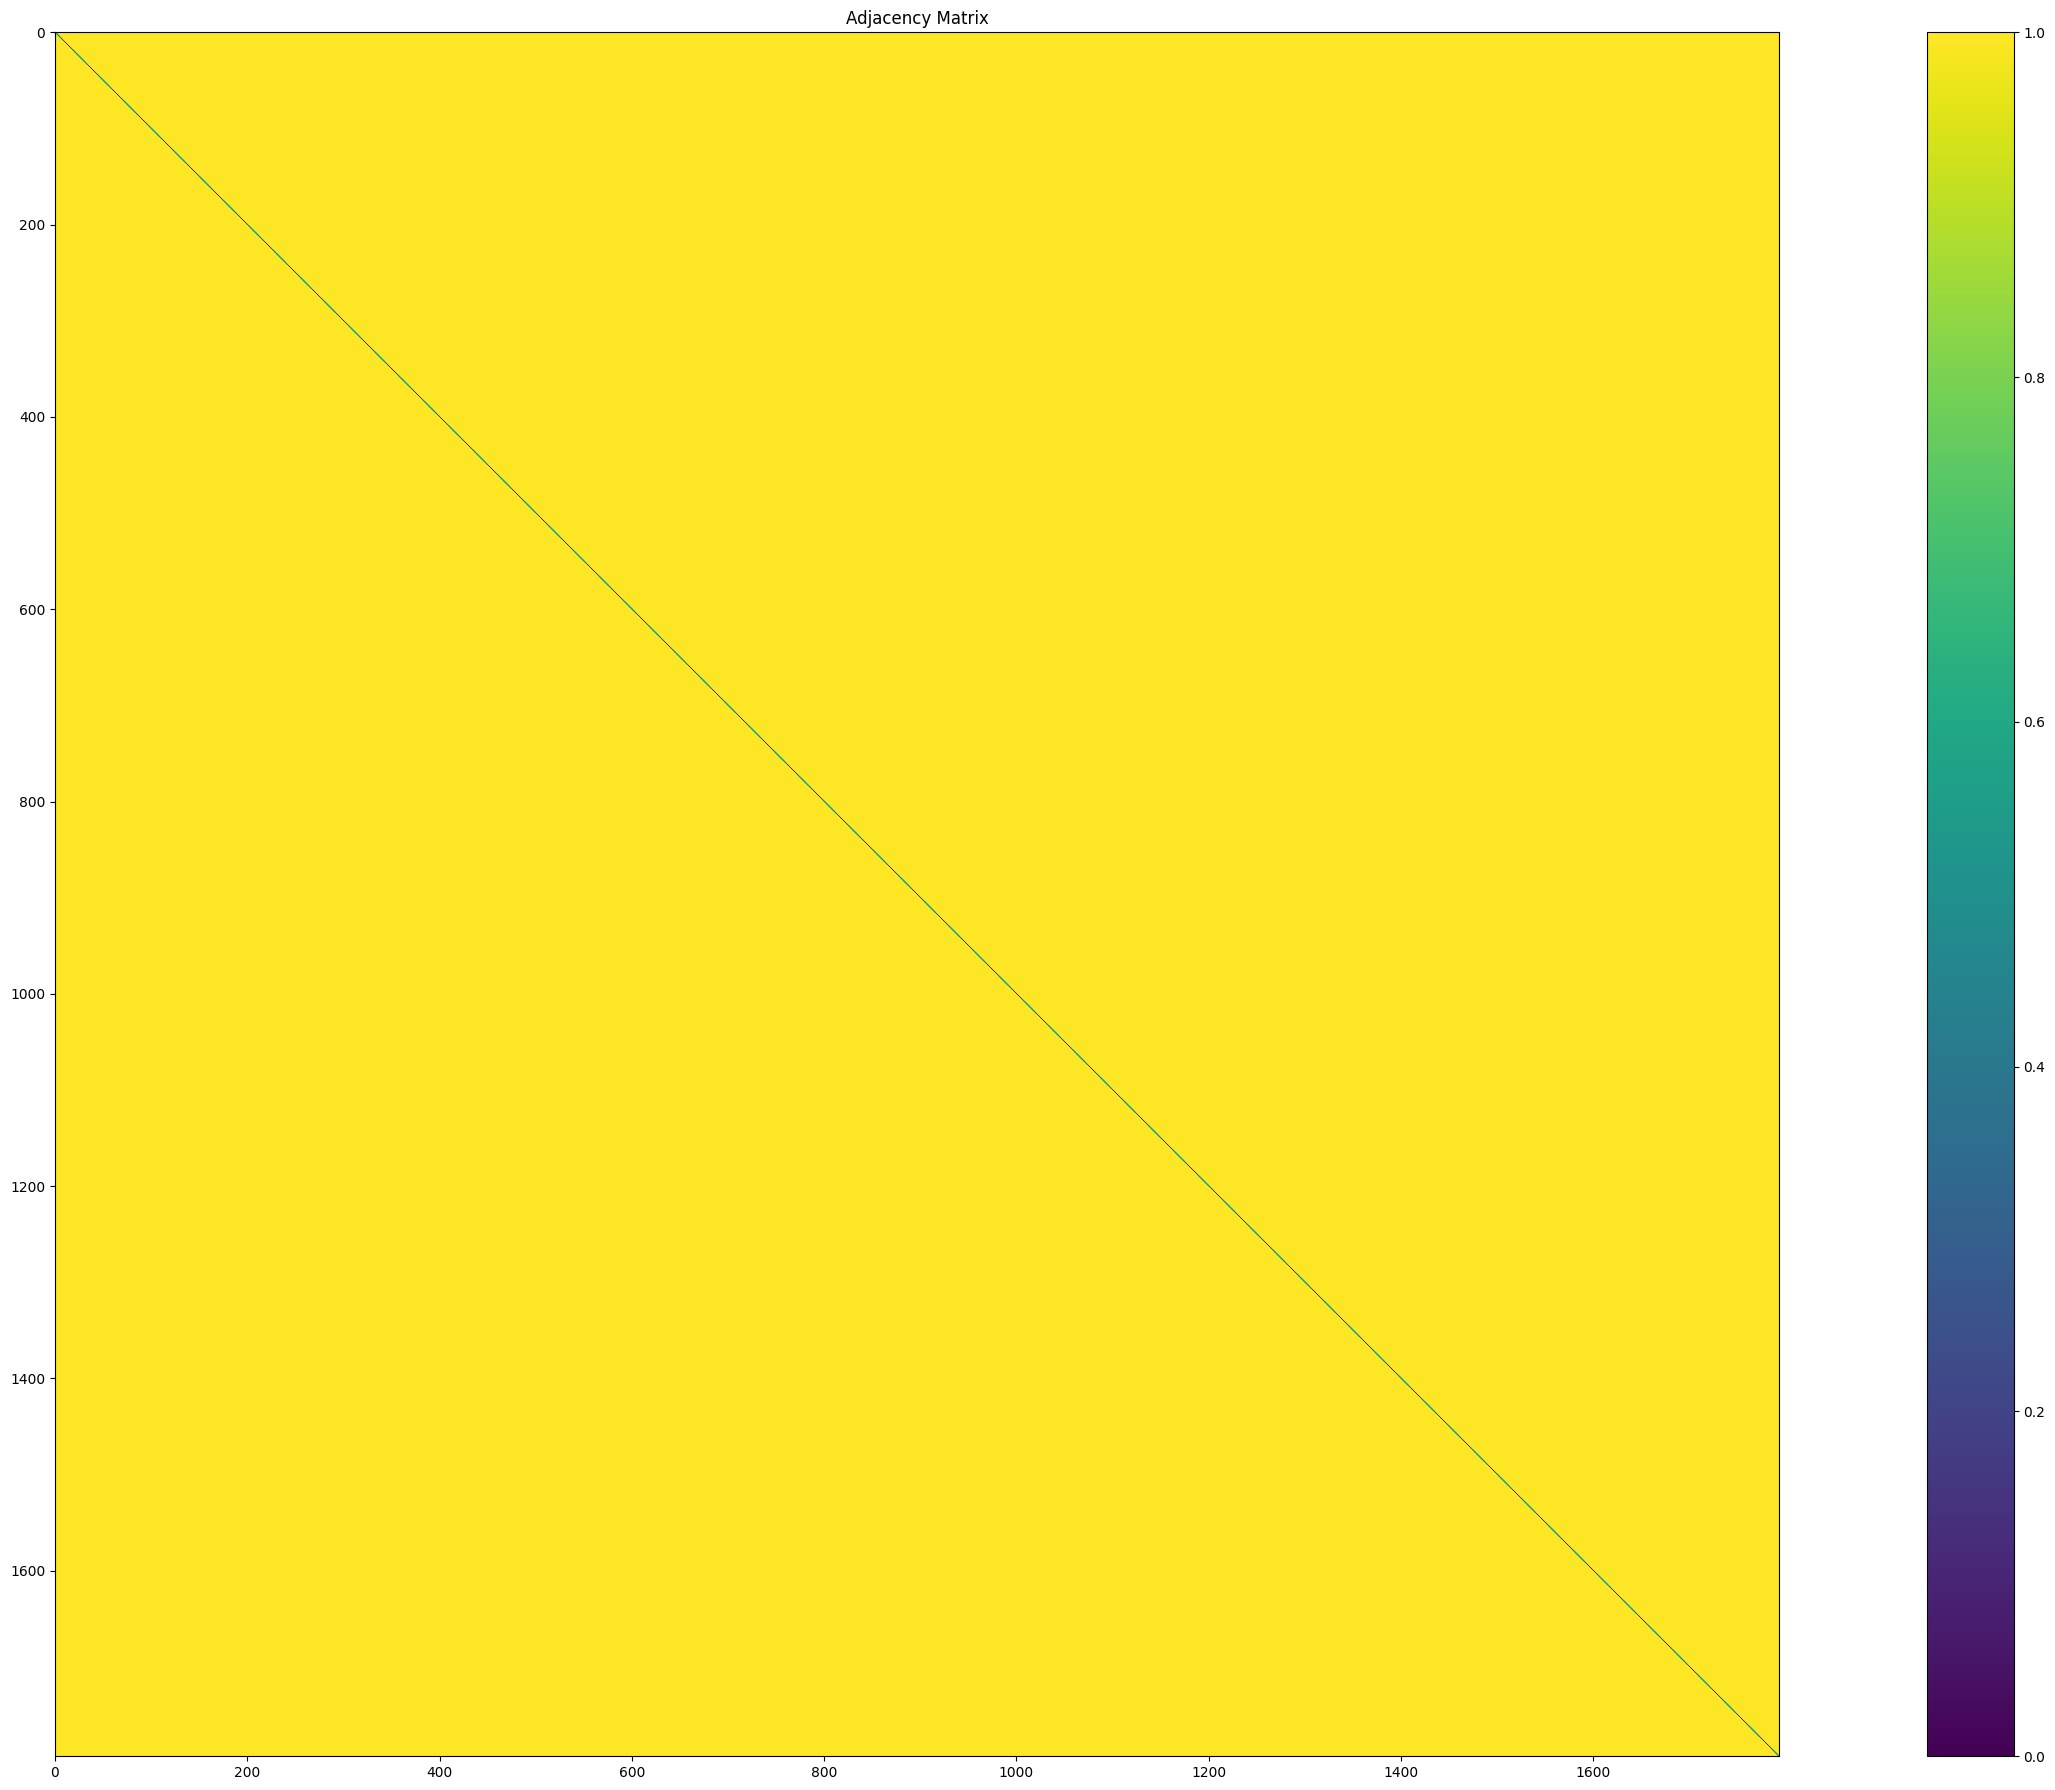

In [7]:
single_graph = custom_dataset_train.edge_index

plot_adj_matrix(single_graph, model_dir=None, node_types=None)


In [8]:
import wandb 

run = wandb.init(
    mode=args.use_wandb,
    # entity="Erencan Tatar", 
    project=f"PredCod",
    name=f"T_{args.T}_lr_value_{args.lr_values}_lr_weights_{args.lr_weights}_",
    id=f"{model_params_name}_{date_hour}",
    # tags= 
    dir=model_dir,
    

    # tags=["param_search", str(model_params["weight_init"]), model_params["activation"],  *learning_params['dataset_transform']], 
    # Track hyperparameters and run metadata
    config={
        "supervised_learning": (graph_params["supervised_learning"]),

        "lr_params": (args.lr_values, args.lr_weights), 
        "T": args.T,

        "graph_structure": args.graph_type, 
        "model_type": args.model_type.lower(), 
        # "graph_structure": custom_dataset_train.edge_index_tensor, 
        # "include_self_connections": dataset_params['include_self_connections'],
        "batch_size": train_loader.batch_size, 
        "use_learning_optimizer": model_params["use_learning_optimizer"],    # False or [0], [(weight_decay=)]
        "weight_init":  model_params["weight_init"],   # xavier, 'uniform', 'based_on_f', 'zero', 'kaiming'
        "activation":  model_params["activation"],  
        "clamping": model_params["clamping"], # (0, torch.inf) or 'None' 

        "numbers_list":         dataset_params["numbers_list"],    
        "N":                    dataset_params['N'],     # taking the first n instances of each digit or use "all"

        "transform": learning_params['dataset_transform'],
    },
)

# Contains graph edge matrix and other parameters so quite big to open.
if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_full.txt", 'w') as file:
        json.dump(params_dict, file, default=default)
    print('Done')

# Store the exact command-line arguments in a text file
import sys
command = ' '.join(sys.argv)
with open(model_dir +'parameter_info/command_log.txt', 'w') as f:
    f.write(command)

with open('trained_models/current_running.txt', 'w') as f:
    f.write(model_dir)

# Save the (small) dictionary to a text file
params_dict_small = {}
keys_to_copy = ['supervised_learning', 'numbers_list', 'NUM_INTERNAL_NODES',  
                'N',  'batch_size','use_learning_optimizer', 'weight_init', 'activation', ]
# copy value from params_dict to params_dict_small
for key in keys_to_copy:
    params_dict_small[key] = params_dict[key]

if "dataset_transform" in params_dict:
    params_dict_small["dataset_transform"] = params_dict["dataset_transform"]

if save_model_params:
    # Save the dictionary to a text file
    with open(model_dir + "parameter_info/params_small.txt", 'w') as file:
        json.dump(params_dict_small, file, default=default)
    print('Done')

print(f"Using batch size of \t: {train_loader.batch_size}")
print("Device \t\t\t:",          device)
print("Model type \t\t:", args.model_type.lower())


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using batch size of 	: 1
Device 			: cuda
Model type 		: ipc


In [9]:
batch

DataBatch(x=[1794, 3, 1], edge_index=[2, 3216642], edge_attr=[3216642], y=[1], batch=[1794], ptr=[2])

In [10]:
# model_params["normalize_msg"] = True 
# model_params["weight_init"] = 0.001
# model_params["weight_init"] = "fixed 0.001"
# model_params["weight_init"] = "normal 0.001"
# model_params["use_learning_optimizer"] = [0.1]
# model_params["use_learning_optimizer"] = False
# model_params["T"] = 50


In [11]:

args.model_type = "ipc"
# args.model_type = "pc"
# 

In [12]:
model_params["use_bias"]

True

In [13]:
model = None 
from helper.plot import plot_energy_during_training

if args.model_type.lower() == "pc":
        
    from models.PC import *

    model = PCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)

    print("-----------Loading PC model-----------")

if args.model_type.lower() == "ipc":
        
    from models.IPC import  *

    model = IPCGNN(**model_params,   
        log_tensorboard=False,
        wandb_logger=run if args.use_wandb in ['online', 'run'] else None,
        debug=False, device=device)
    print("-----------Loading IPC model-----------")

# Magic
# wandb.watch(model, 
#             log="all",   # (str) One of "gradients", "parameters", "all", or None
#             log_freq=10)


from helper.plot import plot_model_weights


save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch0.png')
# plot_model_weights(model, save_path)



######################################################################################################### 
####                                              Model  (training)                                 #####
######################################################################################################### 
model.pc_conv1.set_mode("training")

------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
----- using grokfast: False
----- using use_bias: True
INIT BIAS WITH THE MEAN OF THE DATASET???
Using self.adjust_delta_w,  False
normalize_msg False
-------------initialize--------------
-------------Activation func set to swish--------------
------------------------------------
gradients_minus_1: x and w.grad += 1 * grad
------------------------------------
----- using grokfast: False
----- using use_bias: True
INIT BIAS WITH THE MEAN OF THE DATASET???
Using self.adjust_delta_w,  False
normalize_msg False
-------------initialize--------------
-------------Activation func set to swish--------------
-----------Loading IPC model-----------
vertix 1794
before after 784 784
before after 1000 1000
before after 10 10
-------------mode training--------------
-------------task None--------------


torch.Size([2, 3216642])


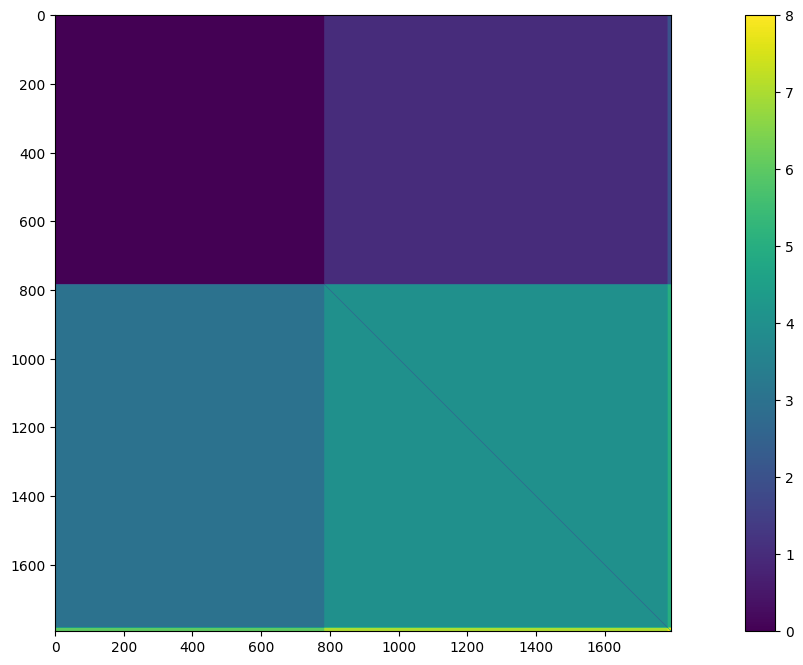

In [14]:
# Extract the edge indices and weights
import scipy.sparse as sp


conn_types = custom_dataset_train.edge_type
if args.graph_type == "fully_connected":
    if conn_types is not None:
        
        edge_index = custom_dataset_train.edge_index
        print(edge_index.shape)
        # Create a sparse matrix using the edge indices and weights
        W_sparse = sp.coo_matrix((conn_types, (edge_index[0], edge_index[1])), shape=(model.pc_conv1.num_vertices, model.pc_conv1.num_vertices))

        # Convert to dense for detailed visualization (if the graph is not too large)
        W = W_sparse.toarray()

        fig, axs = plt.subplots(figsize=(19,8))
        plt.imshow(W)
        plt.colorbar()
        plt.show()

tensor(0.1307)


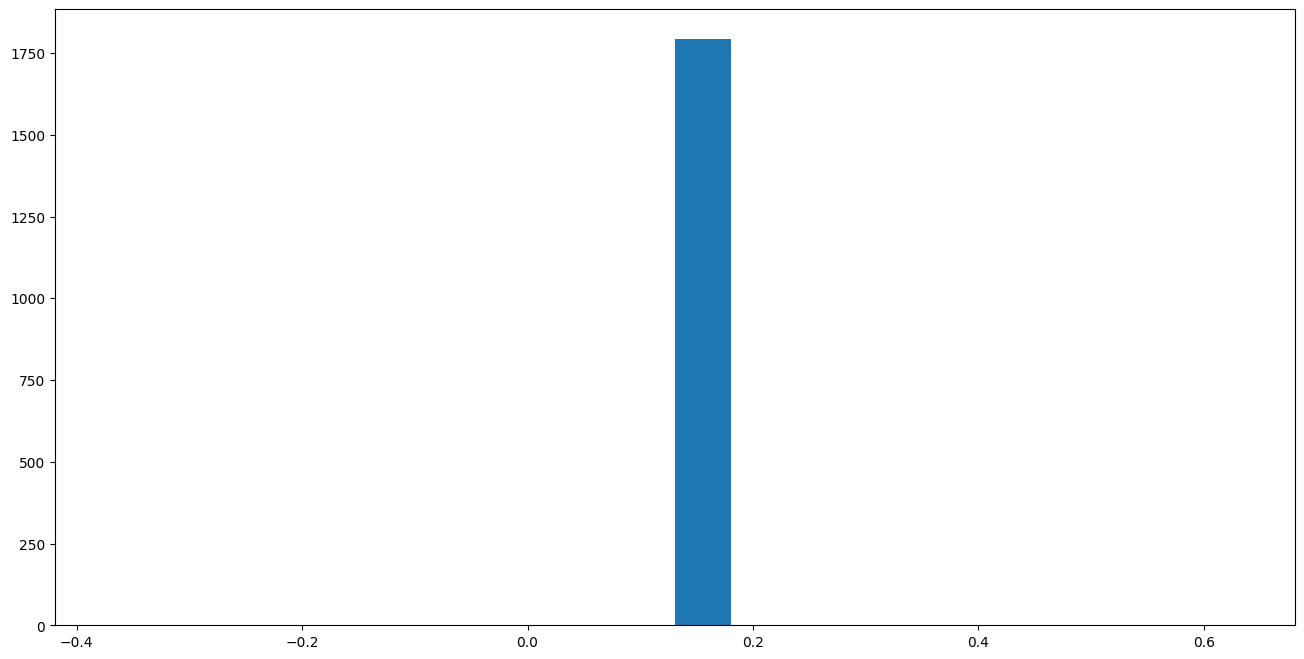

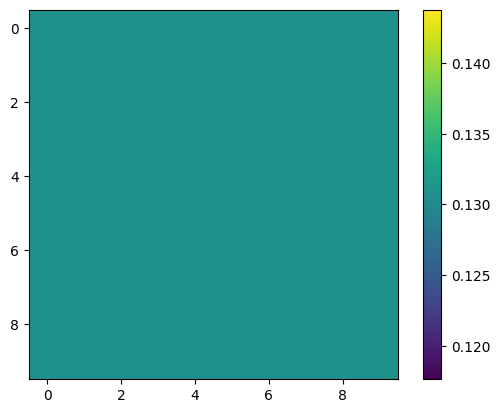

In [15]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:100].reshape(10,10))
    plt.colorbar()
    plt.show()

In [16]:
# assert 1 == 2 

In [17]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

# Learn in stages

In [18]:
# from helper.plot import plot_energy_during_training
# import time
# torch.cuda.empty_cache()

# model = model.to(device)
# print(len(train_loader))
# print("Starting training")

# # Initialize early stopping and history
# earlystop = False
# history = {
#     "internal_energy_per_epoch": [],
#     "sensory_energy_per_epoch": [],
#     "internal_energy_per_batch_last": [],
#     "sensory_energy_per_batch_last": [],
# }

# # Define early stopping threshold and OOM warning
# threshold_earlystop = 0.05
# max_energy_threshold = 1e6

# start_time = time.time()

# # Variables to control staged learning
# current_digit = custom_dataset_train.numbers_list[0]  # start with the first digit
# batch_count_for_digit = 0  # track batches per digit

# for epoch in range(args.epochs):
#     total_loss = 0
#     last_loss = 1e10

#     if earlystop:
#         break

#     train_loader_iter = iter(train_loader)  # Reset the iterator for each epoch
#     while True:
#         torch.cuda.empty_cache()

#         try:
#             # Fetch a batch and check if its label matches the current digit
#             batch, clean = next(train_loader_iter)
#             if batch.y.item() != current_digit:
#                 continue  # Skip this batch if it's not the current digit

#             # Process batch since it matches the current digit
#             batch = batch.to(device)
#             print("Label:", batch.y.item(), "Input Shape:", batch.x.shape)
#             model.train()

#             history_epoch = model.learning(batch)

#             # Append energy values to history
#             history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
#             history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])
#             history["internal_energy_per_batch_last"].append(history_epoch["internal_energy_last"])
#             history["sensory_energy_per_batch_last"].append(history_epoch["sensory_energy_last"])

#             model.pc_conv1.restart_activity()
#             batch_count_for_digit += 1
#             print(f"------------------ Epoch {epoch}: Batch for digit {current_digit}: {batch_count_for_digit} ------------------")

#             # Check for early stopping conditions
#             if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
#                 earlystop = True
#                 print(f"EARLY STOPPED at epoch {epoch}")
#                 print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
#                 break

#             if history_epoch["internal_energy_mean"] > max_energy_threshold:
#                 print("Energy too high, stopping training")
#                 earlystop = True
#                 break

#             # Once we've processed 10 batches for the current digit, move to the next one
#             if batch_count_for_digit >= 10:
#                 batch_count_for_digit = 0
#                 current_digit = (current_digit + 1) % 10  # cycle through 0-9
#                 print(f"Moving to next digit: {current_digit}")

#                 # Plot energies and save checkpoint if desired
#                 plot_energy_during_training(
#                     model.pc_conv1.energy_vals["internal_energy"][:],
#                     model.pc_conv1.energy_vals["sensory_energy"][:],
#                     history,
#                     model_dir=model_dir,
#                     epoch=epoch
#                 )
#                 break
        
#         except StopIteration:
#             # End the loop if we've exhausted the data loader
#             print("End of DataLoader reached, stopping epoch.")
#             break

#         except RuntimeError as e:
#             if 'out of memory' in str(e):
#                 print('WARNING: CUDA ran out of memory, skipping batch...')
#                 torch.cuda.empty_cache()
#                 continue
#             else:
#                 torch.cuda.empty_cache()
#                 raise e

#     print(f"Epoch {epoch} / {args.epochs} completed")

# end_time = time.time()
# print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


# Original Learning

In [19]:
from helper.plot import plot_energy_during_training

import time 
torch.cuda.empty_cache()

training_labels = [] 
from collections import Counter


print(model)      

model = model.to(device)
# assert train_loader.batch_size == 1
print(len(train_loader))
print("Starting training")


# Initialize early stopping and history
earlystop = False
history = {
    "internal_energy_per_epoch": [],
    "sensory_energy_per_epoch": [],
    "internal_energy_per_batch_last": [],
    "sensory_energy_per_batch_last": [],
}

# Define the early stopping threshold and OOM warning
threshold_earlystop = 0.05
max_energy_threshold = 1e6

start_time = time.time()

for epoch in range(args.epochs):
# for epoch in range(1):
    total_loss = 0
    last_loss = 1e10

    if earlystop:
        break

    for idx, (batch, clean) in enumerate(train_loader):
        torch.cuda.empty_cache()
        
        training_labels.append(int(batch.y))
        try:
            print("Label:", batch.y, "Input Shape:", batch.x.shape)
            model.train()
            # model.pc_conv1.restart_activity()

            batch = batch.to(device)
            history_epoch = model.learning(batch)

            # Append energy values to history
            history["internal_energy_per_epoch"].append(history_epoch["internal_energy_mean"])
            history["sensory_energy_per_epoch"].append(history_epoch["sensory_energy_mean"])
            history["internal_energy_per_batch_last"].append(history_epoch["internal_energy_last"])
            history["sensory_energy_per_batch_last"].append(history_epoch["sensory_energy_last"])

            model.pc_conv1.restart_activity()

            print(f"------------------ Epoch {epoch}: Batch {idx} ------------------")

            # Periodic checkpoint saving and plotting


            # Early stopping based on loss change
            if abs(last_loss - history_epoch["internal_energy_mean"]) < threshold_earlystop:
                print()
                earlystop = True
                print(f"EARLY STOPPED at epoch {epoch}")
                print(f"Last Loss: {last_loss}, Current Loss: {history_epoch['internal_energy_mean']}")
                break

            # Early stopping based on high energy
            if history_epoch["internal_energy_mean"] > max_energy_threshold:
                print("energy :", history_epoch["internal_energy_mean"])
                print("Energy too high, stopping training")
                earlystop = True
                break

            if idx >= 10:
                print("Epoch checkpoint reached, saving model...")

                # model_filename = f"model_state_dict_{epoch}.pth"
                # model_path = os.path.join(model_dir, model_filename)
                # torch.save(model.state_dict(), model_path)


                from helper.plot import plot_energy_during_training

                plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                                            model.pc_conv1.energy_vals["sensory_energy"][:],
                                            history, 
                                            model_dir=model_dir,
                                            epoch=epoch)

                break 


        
        except RuntimeError as e:
            
            if 'out of memory' in str(e):
                print('WARNING: CUDA ran out of memory, skipping batch...')
                torch.cuda.empty_cache()
                continue
            else:
                torch.cuda.empty_cache()
                raise e

    print(f"Epoch {epoch} / {args.epochs} completed")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds for {args.epochs} epochs")


# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
# plot_model_weights(model, save_path)

if earlystop:
    print("Stopping program-------")
    # Open the file in write mode
    with open(model_dir + "early_stopped_training.txt", 'w') as file:
        # Write each list to the file

        file.write("Stopped training :\n")
    exit()


IPCGNN(
  (pc_conv1): IPCGraphConv(
    (prediction_mp): PredictionMessagePassing()
    (values_mp): ValueMessagePassing()
  )
)
36012
Starting training
Done for idx 26356
Done for idx 2248
Done for idx 6484
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 8.069498062133789


Total energy at time 0 {'internal_energy': 8.069498062133789, 'supervised_energy': 48.085113525390625, 'sensory_energy': 47.2820930480957, 'energy_total': 103.43670654296875}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7830, device='cuda:0') tensor(-0.0978, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0548, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 7.82382869720459, 'supervised_energy': 47.49654769897461, 'sensory_energy': 46.48271942138672, 'energy_total': 101.80309295654297},:  20%|██        | 1/5 [00:00<00:00,  4.82it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Total energy at time 2 / 5 {'internal_energy': 7.603318214416504, 'supervised_energy': 46.92750930786133, 'sensory_energy': 45.708473205566406, 'energy_total': 100.23930358886719},:  40%|████      | 2/5 [00:00<00:00,  6.54it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7222, device='cuda:0') tensor(-0.0984, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0558, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6631, device='cuda:0') tensor(-0.0990, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0568, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 7.228623390197754, 'supervised_energy': 45.84291076660156, 'sensory_energy': 44.23237991333008, 'energy_total': 97.30392456054688},:  80%|████████  | 4/5 [00:00<00:00,  7.63it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6055, device='cuda:0') tensor(-0.0996, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0577, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5495, device='cuda:0') tensor(-0.1002, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0585, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 23047


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 7.069249629974365
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 7.069249629974365
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 0 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 6.427734375


Total energy at time 0 {'internal_energy': 6.427734375, 'supervised_energy': 47.51456069946289, 'sensory_energy': 38.716217041015625, 'energy_total': 92.65850830078125}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7273, device='cuda:0') tensor(-0.0966, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0467, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 6.276628494262695, 'supervised_energy': 47.072021484375, 'sensory_energy': 38.16804885864258, 'energy_total': 91.5167007446289},:  20%|██        | 1/5 [00:00<00:00,  7.67it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6814, device='cuda:0') tensor(-0.0971, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0474, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 6.140310287475586, 'supervised_energy': 46.64145278930664, 'sensory_energy': 37.63317108154297, 'energy_total': 90.4149398803711},:  40%|████      | 2/5 [00:00<00:00,  8.18it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6366, device='cuda:0') tensor(-0.0975, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0481, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 6.018424987792969, 'supervised_energy': 46.22212600708008, 'sensory_energy': 37.10921859741211, 'energy_total': 89.34976959228516},:  60%|██████    | 3/5 [00:00<00:00,  8.32it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5927, device='cuda:0') tensor(-0.0980, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0487, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 5.908258438110352, 'supervised_energy': 45.81367492675781, 'sensory_energy': 36.59699630737305, 'energy_total': 88.31893920898438},:  80%|████████  | 4/5 [00:00<00:00,  8.37it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5499, device='cuda:0') tensor(-0.0985, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0492, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 5.809000015258789
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 5.809000015258789
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 1 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
11451


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.443469047546387


Total energy at time 0 {'internal_energy': 7.443469047546387, 'supervised_energy': 46.87807083129883, 'sensory_energy': 40.651885986328125, 'energy_total': 94.97341918945312}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6599, device='cuda:0') tensor(-0.1005, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0516, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 7.249811172485352, 'supervised_energy': 46.41843795776367, 'sensory_energy': 40.06776428222656, 'energy_total': 93.73602294921875},:  20%|██        | 1/5 [00:00<00:00,  8.03it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6119, device='cuda:0') tensor(-0.1010, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0524, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 7.074664115905762, 'supervised_energy': 45.97200012207031, 'sensory_energy': 39.49846267700195, 'energy_total': 92.54513549804688},:  40%|████      | 2/5 [00:00<00:00,  8.16it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5650, device='cuda:0') tensor(-0.1015, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0532, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 6.9180908203125, 'supervised_energy': 45.538475036621094, 'sensory_energy': 38.944679260253906, 'energy_total': 91.4012451171875},:  60%|██████    | 3/5 [00:00<00:00,  8.29it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5193, device='cuda:0') tensor(-0.1020, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0539, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 6.776734352111816, 'supervised_energy': 45.11671447753906, 'sensory_energy': 38.40480422973633, 'energy_total': 90.29824829101562},:  80%|████████  | 4/5 [00:00<00:00,  8.31it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4746, device='cuda:0') tensor(-0.1026, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0546, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 18768
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.650216102600098
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.650216102600098
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 2 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.969542503356934


Total energy at time 0 {'internal_energy': 7.969542503356934, 'supervised_energy': 48.09402084350586, 'sensory_energy': 46.82078552246094, 'energy_total': 102.88434600830078}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7836, device='cuda:0') tensor(-0.0976, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0544, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 7.727980613708496, 'supervised_energy': 47.51340866088867, 'sensory_energy': 46.040321350097656, 'energy_total': 101.28170776367188},:  20%|██        | 1/5 [00:00<00:00,  8.19it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7237, device='cuda:0') tensor(-0.0981, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0555, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 7.5115861892700195, 'supervised_energy': 46.951717376708984, 'sensory_energy': 45.28498077392578, 'energy_total': 99.74827575683594},:  40%|████      | 2/5 [00:00<00:00,  8.08it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6655, device='cuda:0') tensor(-0.0987, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0564, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 7.31690788269043, 'supervised_energy': 46.40776443481445, 'sensory_energy': 44.552886962890625, 'energy_total': 98.27755737304688},:  60%|██████    | 3/5 [00:00<00:00,  8.12it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6087, device='cuda:0') tensor(-0.0993, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0573, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 7.1427226066589355, 'supervised_energy': 45.880645751953125, 'sensory_energy': 43.841983795166016, 'energy_total': 96.8653564453125},:  80%|████████  | 4/5 [00:00<00:00,  8.31it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5534, device='cuda:0') tensor(-0.0999, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0581, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 18530
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.986209869384766
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.986209869384766
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 3 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 3.6290786266326904


Total energy at time 0 {'internal_energy': 3.6290786266326904, 'supervised_energy': 48.44148635864258, 'sensory_energy': 28.1573486328125, 'energy_total': 80.22791290283203}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8246, device='cuda:0') tensor(-0.0886, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0306, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 3.603306770324707, 'supervised_energy': 48.1502685546875, 'sensory_energy': 27.809783935546875, 'energy_total': 79.56336212158203},:  20%|██        | 1/5 [00:00<00:00,  7.94it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7949, device='cuda:0') tensor(-0.0889, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0308, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 3.580878496170044, 'supervised_energy': 47.86402130126953, 'sensory_energy': 27.466140747070312, 'energy_total': 78.91104125976562},:  40%|████      | 2/5 [00:00<00:00,  8.06it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7656, device='cuda:0') tensor(-0.0892, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0309, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 3.560764789581299, 'supervised_energy': 47.582759857177734, 'sensory_energy': 27.12683868408203, 'energy_total': 78.2703628540039},:  60%|██████    | 3/5 [00:00<00:00,  8.07it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7367, device='cuda:0') tensor(-0.0895, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0310, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 3.543585777282715, 'supervised_energy': 47.30619812011719, 'sensory_energy': 26.791439056396484, 'energy_total': 77.64122009277344},:  80%|████████  | 4/5 [00:00<00:00,  8.15it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7083, device='cuda:0') tensor(-0.0898, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0311, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 3.5286598205566406
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 3.5286598205566406
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 4 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
4130


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 2.157168388366699


Total energy at time 0 {'internal_energy': 2.157168388366699, 'supervised_energy': 48.58661651611328, 'sensory_energy': 19.386829376220703, 'energy_total': 70.130615234375}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8441, device='cuda:0') tensor(-0.0843, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0194, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 2.1887710094451904, 'supervised_energy': 48.42865753173828, 'sensory_energy': 19.153596878051758, 'energy_total': 69.77102661132812},:  20%|██        | 1/5 [00:00<00:00,  8.29it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8281, device='cuda:0') tensor(-0.0845, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0191, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 2.219040632247925, 'supervised_energy': 48.271697998046875, 'sensory_energy': 18.924312591552734, 'energy_total': 69.41505432128906},:  40%|████      | 2/5 [00:00<00:00,  8.08it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8121, device='cuda:0') tensor(-0.0848, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0188, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 2.248141288757324, 'supervised_energy': 48.115787506103516, 'sensory_energy': 18.69882583618164, 'energy_total': 69.06275177001953},:  60%|██████    | 3/5 [00:00<00:00,  8.08it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7963, device='cuda:0') tensor(-0.0850, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0186, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 2.276066780090332, 'supervised_energy': 47.961002349853516, 'sensory_energy': 18.47693634033203, 'energy_total': 68.71400451660156},:  80%|████████  | 4/5 [00:00<00:00,  8.39it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7805, device='cuda:0') tensor(-0.0852, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0184, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 22297
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 2.3029403686523438
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 2.3029403686523438
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 5 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 9.053187370300293


Total energy at time 0 {'internal_energy': 9.053187370300293, 'supervised_energy': 48.118473052978516, 'sensory_energy': 48.94951248168945, 'energy_total': 106.12117004394531}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7753, device='cuda:0') tensor(-0.1006, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0592, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 8.75888442993164, 'supervised_energy': 47.49932861328125, 'sensory_energy': 48.11024856567383, 'energy_total': 104.36845397949219},:  20%|██        | 1/5 [00:00<00:00,  5.32it/s]

!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7114, device='cuda:0') tensor(-0.1012, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0604, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 8.49402904510498, 'supervised_energy': 46.902069091796875, 'sensory_energy': 47.30035400390625, 'energy_total': 102.69644927978516},:  40%|████      | 2/5 [00:00<00:00,  6.66it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6495, device='cuda:0') tensor(-0.1018, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0615, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 8.258241653442383, 'supervised_energy': 46.32535171508789, 'sensory_energy': 46.5184326171875, 'energy_total': 101.10202026367188},:  60%|██████    | 3/5 [00:00<00:00,  7.29it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5892, device='cuda:0') tensor(-0.1025, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0625, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 8.045696258544922, 'supervised_energy': 45.76791000366211, 'sensory_energy': 45.76166915893555, 'energy_total': 99.57527923583984},:  80%|████████  | 4/5 [00:00<00:00,  7.64it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5307, device='cuda:0') tensor(-0.1032, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0634, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 23424
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 7.8558197021484375
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 7.8558197021484375
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 6 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 5.824725151062012


Total energy at time 0 {'internal_energy': 5.824725151062012, 'supervised_energy': 47.14275360107422, 'sensory_energy': 35.849632263183594, 'energy_total': 88.8171157836914}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6837, device='cuda:0') tensor(-0.0972, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0436, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 5.71058464050293, 'supervised_energy': 46.74193572998047, 'sensory_energy': 35.36912536621094, 'energy_total': 87.8216552734375},:  20%|██        | 1/5 [00:00<00:00,  7.91it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6421, device='cuda:0') tensor(-0.0976, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0441, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 5.608042240142822, 'supervised_energy': 46.351078033447266, 'sensory_energy': 34.897274017333984, 'energy_total': 86.85639190673828},:  40%|████      | 2/5 [00:00<00:00,  8.28it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6014, device='cuda:0') tensor(-0.0980, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0446, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 5.516350746154785, 'supervised_energy': 45.969566345214844, 'sensory_energy': 34.433921813964844, 'energy_total': 85.91984558105469},:  60%|██████    | 3/5 [00:00<00:00,  8.41it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5614, device='cuda:0') tensor(-0.0984, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0451, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 5.433359146118164, 'supervised_energy': 45.597354888916016, 'sensory_energy': 33.978973388671875, 'energy_total': 85.00968933105469},:  80%|████████  | 4/5 [00:00<00:00,  8.47it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5223, device='cuda:0') tensor(-0.0989, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0455, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 16908
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 5.358611106872559
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 5.358611106872559
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 7 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 9.977653503417969


Total energy at time 0 {'internal_energy': 9.977653503417969, 'supervised_energy': 47.238948822021484, 'sensory_energy': 48.63114929199219, 'energy_total': 105.84774780273438}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6835, device='cuda:0') tensor(-0.1042, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0630, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 9.64293098449707, 'supervised_energy': 46.637996673583984, 'sensory_energy': 47.810977935791016, 'energy_total': 104.09191131591797},:  20%|██        | 1/5 [00:00<00:00,  8.10it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6209, device='cuda:0') tensor(-0.1048, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0642, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 9.342402458190918, 'supervised_energy': 46.05903244018555, 'sensory_energy': 47.02220153808594, 'energy_total': 102.42363739013672},:  40%|████      | 2/5 [00:00<00:00,  8.51it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5603, device='cuda:0') tensor(-0.1054, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0654, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 9.073186874389648, 'supervised_energy': 45.5008659362793, 'sensory_energy': 46.26213073730469, 'energy_total': 100.836181640625},:  60%|██████    | 3/5 [00:00<00:00,  7.26it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5015, device='cuda:0') tensor(-0.1061, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0665, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 8.832900047302246, 'supervised_energy': 44.96206283569336, 'sensory_energy': 45.52861785888672, 'energy_total': 99.32357788085938},:  80%|████████  | 4/5 [00:00<00:00,  7.05it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4444, device='cuda:0') tensor(-0.1068, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0675, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idxdelta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 8.61656665802002
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 8.61656665802002
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 8 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
 32856


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 4.8750762939453125


Total energy at time 0 {'internal_energy': 4.8750762939453125, 'supervised_energy': 47.81896209716797, 'sensory_energy': 34.87364196777344, 'energy_total': 87.56768035888672}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7540, device='cuda:0') tensor(-0.0938, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0386, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 4.801709175109863, 'supervised_energy': 47.427913665771484, 'sensory_energy': 34.39353561401367, 'energy_total': 86.62315368652344},:  20%|██        | 1/5 [00:00<00:00,  7.55it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7137, device='cuda:0') tensor(-0.0942, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0390, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 4.735624313354492, 'supervised_energy': 47.04539108276367, 'sensory_energy': 33.92143249511719, 'energy_total': 85.70243835449219},:  40%|████      | 2/5 [00:00<00:00,  7.61it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6742, device='cuda:0') tensor(-0.0945, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0393, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 4.676212787628174, 'supervised_energy': 46.67111587524414, 'sensory_energy': 33.45661163330078, 'energy_total': 84.80393981933594},:  60%|██████    | 3/5 [00:00<00:00,  7.62it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6354, device='cuda:0') tensor(-0.0949, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0396, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 4.622981071472168, 'supervised_energy': 46.30479431152344, 'sensory_energy': 32.99949264526367, 'energy_total': 83.9272689819336},:  80%|████████  | 4/5 [00:00<00:00,  7.86it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5973, device='cuda:0') tensor(-0.0953, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0399, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idxdelta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 4.575850486755371
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 4.575850486755371
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 9 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
 11163


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 2.705476760864258


Total energy at time 0 {'internal_energy': 2.705476760864258, 'supervised_energy': 47.7759895324707, 'sensory_energy': 23.18358612060547, 'energy_total': 73.66505432128906}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7578, device='cuda:0') tensor(-0.0892, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0240, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 2.727351188659668, 'supervised_energy': 47.56306076049805, 'sensory_energy': 22.895851135253906, 'energy_total': 73.1862564086914},:  20%|██        | 1/5 [00:00<00:00,  7.52it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7359, device='cuda:0') tensor(-0.0895, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0238, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 2.7488186359405518, 'supervised_energy': 47.35246658325195, 'sensory_energy': 22.61245346069336, 'energy_total': 72.71373748779297},:  40%|████      | 2/5 [00:00<00:00,  7.72it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7143, device='cuda:0') tensor(-0.0897, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0236, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 2.769707202911377, 'supervised_energy': 47.144222259521484, 'sensory_energy': 22.333049774169922, 'energy_total': 72.24697875976562},:  60%|██████    | 3/5 [00:00<00:00,  7.55it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6929, device='cuda:0') tensor(-0.0900, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0235, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 2.790344715118408, 'supervised_energy': 46.938438415527344, 'sensory_energy': 22.057598114013672, 'energy_total': 71.78638458251953},:  80%|████████  | 4/5 [00:00<00:00,  7.57it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6716, device='cuda:0') tensor(-0.0903, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0233, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 2.8101799488067627
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 2.8101799488067627
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 0: Batch 10 ------------------
Epoch checkpoint reached, saving model...


Epoch 0 / 10 completed
Done for idx 21698
Done for idx 33036Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])

-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.174648284912109


Total energy at time 0 {'internal_energy': 7.174648284912109, 'supervised_energy': 45.67911911010742, 'sensory_energy': 39.27149963378906, 'energy_total': 92.1252670288086}:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx 24685
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5179, device='cuda:0') tensor(-0.1042, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0503, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 7.014188766479492, 'supervised_energy': 45.23262405395508, 'sensory_energy': 38.716697692871094, 'energy_total': 90.96351623535156},:  20%|██        | 1/5 [00:00<00:00,  7.38it/s]

torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4707, device='cuda:0') tensor(-0.1047, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0510, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 6.8698015213012695, 'supervised_energy': 44.798397064208984, 'sensory_energy': 38.173858642578125, 'energy_total': 89.8420639038086},:  40%|████      | 2/5 [00:00<00:00,  7.39it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4247, device='cuda:0') tensor(-0.1052, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0517, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 6.740199089050293, 'supervised_energy': 44.3758659362793, 'sensory_energy': 37.64315414428711, 'energy_total': 88.75921630859375},:  60%|██████    | 3/5 [00:00<00:00,  7.58it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3796, device='cuda:0') tensor(-0.1057, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0523, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 6.623358726501465, 'supervised_energy': 43.96451187133789, 'sensory_energy': 37.124183654785156, 'energy_total': 87.71205139160156},:  80%|████████  | 4/5 [00:00<00:00,  7.76it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3356, device='cuda:0') tensor(-0.1062, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0528, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Done for idx 24488


Final internal energy (t=T): 6.51927375793457
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.51927375793457
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 0 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 4.303564071655273


Total energy at time 0 {'internal_energy': 4.303564071655273, 'supervised_energy': 46.24324035644531, 'sensory_energy': 32.483970642089844, 'energy_total': 83.03077697753906}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5888, device='cuda:0') tensor(-0.0969, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0350, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 4.274232864379883, 'supervised_energy': 45.892250061035156, 'sensory_energy': 32.03022766113281, 'energy_total': 82.19670867919922},:  20%|██        | 1/5 [00:00<00:00,  5.79it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5521, device='cuda:0') tensor(-0.0973, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0352, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 4.248642444610596, 'supervised_energy': 45.54763412475586, 'sensory_energy': 31.5833797454834, 'energy_total': 81.37965393066406},:  40%|████      | 2/5 [00:00<00:00,  6.43it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5159, device='cuda:0') tensor(-0.0976, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0353, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 4.226284503936768, 'supervised_energy': 45.20956802368164, 'sensory_energy': 31.14350128173828, 'energy_total': 80.57935333251953},:  60%|██████    | 3/5 [00:00<00:00,  6.56it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4803, device='cuda:0') tensor(-0.0980, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0354, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 4.2071146965026855, 'supervised_energy': 44.87765121459961, 'sensory_energy': 30.7100772857666, 'energy_total': 79.79484558105469},:  80%|████████  | 4/5 [00:00<00:00,  6.84it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4453, device='cuda:0') tensor(-0.0984, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0356, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 4.191047668457031
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 4.191047668457031
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 1 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])


Done for idx 6146
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 8.919426918029785


Total energy at time 0 {'internal_energy': 8.919426918029785, 'supervised_energy': 46.41991424560547, 'sensory_energy': 46.720584869384766, 'energy_total': 102.05992126464844}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6087, device='cuda:0') tensor(-0.1051, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0584, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 8.656235694885254, 'supervised_energy': 45.873844146728516, 'sensory_energy': 45.97773742675781, 'energy_total': 100.5078125},:  20%|██        | 1/5 [00:00<00:00,  6.41it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5515, device='cuda:0') tensor(-0.1056, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0595, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 8.419095993041992, 'supervised_energy': 45.345401763916016, 'sensory_energy': 45.25938415527344, 'energy_total': 99.02388000488281},:  40%|████      | 2/5 [00:00<00:00,  5.49it/s]

!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4959, device='cuda:0') tensor(-0.1062, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0605, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 8.2072114944458, 'supervised_energy': 44.83380889892578, 'sensory_energy': 44.562400817871094, 'energy_total': 97.6034164428711},:  60%|██████    | 3/5 [00:00<00:00,  5.91it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4417, device='cuda:0') tensor(-0.1068, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0614, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 8.016236305236816, 'supervised_energy': 44.337806701660156, 'sensory_energy': 43.88615417480469, 'energy_total': 96.24019622802734},:  80%|████████  | 4/5 [00:00<00:00,  6.34it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3889, device='cuda:0') tensor(-0.1074, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0622, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 7.846007347106934
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 7.846007347106934
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 2 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])


Done for idx 11733
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 11.496074676513672


Total energy at time 0 {'internal_energy': 11.496074676513672, 'supervised_energy': 43.30636978149414, 'sensory_energy': 45.9271240234375, 'energy_total': 100.72956848144531}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2530, device='cuda:0') tensor(-0.1148, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0686, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 11.125130653381348, 'supervised_energy': 42.76652145385742, 'sensory_energy': 45.203285217285156, 'energy_total': 99.09494018554688},:  20%|██        | 1/5 [00:00<00:00,  7.03it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1944, device='cuda:0') tensor(-0.1154, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0699, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 10.792830467224121, 'supervised_energy': 42.247432708740234, 'sensory_energy': 44.508087158203125, 'energy_total': 97.54834747314453},:  40%|████      | 2/5 [00:00<00:00,  6.98it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1377, device='cuda:0') tensor(-0.1161, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0711, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 10.495962142944336, 'supervised_energy': 41.74796676635742, 'sensory_energy': 43.840049743652344, 'energy_total': 96.08396911621094},:  60%|██████    | 3/5 [00:00<00:00,  7.26it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0828, device='cuda:0') tensor(-0.1168, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0722, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 10.229632377624512, 'supervised_energy': 41.26588439941406, 'sensory_energy': 43.195159912109375, 'energy_total': 94.690673828125},:  80%|████████  | 4/5 [00:00<00:00,  7.58it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0295, device='cuda:0') tensor(-0.1175, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0733, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 9.990581512451172
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 9.990581512451172
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 3 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
22871


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 6.32740592956543


Total energy at time 0 {'internal_energy': 6.32740592956543, 'supervised_energy': 43.25135040283203, 'sensory_energy': 34.014827728271484, 'energy_total': 83.59358215332031}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2702, device='cuda:0') tensor(-0.1079, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0458, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 6.14868688583374, 'supervised_energy': 42.56617736816406, 'sensory_energy': 33.17278289794922, 'energy_total': 81.88764190673828},:  40%|████      | 2/5 [00:00<00:00,  5.61it/s]  

!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2327, device='cuda:0') tensor(-0.1083, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0462, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1959, device='cuda:0') tensor(-0.1088, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0466, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 6.004968166351318, 'supervised_energy': 41.910850524902344, 'sensory_energy': 32.35865783691406, 'energy_total': 80.27447509765625},:  80%|████████  | 4/5 [00:00<00:00,  7.05it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1598, device='cuda:0') tensor(-0.1092, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0470, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1243, device='cuda:0') tensor(-0.1096, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0473, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 12095


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 5.944462299346924
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 5.944461822509766
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 4 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 2.720815658569336


Total energy at time 0 {'internal_energy': 2.720815658569336, 'supervised_energy': 48.500736236572266, 'sensory_energy': 21.67888641357422, 'energy_total': 72.90044403076172}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8336, device='cuda:0') tensor(-0.0864, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0244, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 2.732576608657837, 'supervised_energy': 48.31156921386719, 'sensory_energy': 21.438650131225586, 'energy_total': 72.48280334472656},:  20%|██        | 1/5 [00:00<00:00,  6.64it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.8144, device='cuda:0') tensor(-0.0866, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0243, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 2.74426531791687, 'supervised_energy': 48.12454605102539, 'sensory_energy': 21.201431274414062, 'energy_total': 72.07025146484375},:  40%|████      | 2/5 [00:00<00:00,  7.40it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7953, device='cuda:0') tensor(-0.0869, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0242, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 2.7558979988098145, 'supervised_energy': 47.939666748046875, 'sensory_energy': 20.966943740844727, 'energy_total': 71.66251373291016},:  60%|██████    | 3/5 [00:00<00:00,  7.64it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7764, device='cuda:0') tensor(-0.0871, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0241, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 2.767723560333252, 'supervised_energy': 47.75688934326172, 'sensory_energy': 20.735416412353516, 'energy_total': 71.2600326538086},:  80%|████████  | 4/5 [00:00<00:00,  7.77it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7577, device='cuda:0') tensor(-0.0874, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0240, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 2.7794742584228516
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 2.7794742584228516
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 5 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 35144


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 6.783816814422607


Total energy at time 0 {'internal_energy': 6.783816814422607, 'supervised_energy': 48.27063751220703, 'sensory_energy': 41.38349914550781, 'energy_total': 96.43795776367188}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7928, device='cuda:0') tensor(-0.0968, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0490, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Total energy at time 2 / 5 {'internal_energy': 6.452312469482422, 'supervised_energy': 47.2879753112793, 'sensory_energy': 40.177059173583984, 'energy_total': 93.91734313964844},:  40%|████      | 2/5 [00:00<00:00,  6.07it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7418, device='cuda:0') tensor(-0.0972, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0498, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6921, device='cuda:0') tensor(-0.0977, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0506, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 6.183954238891602, 'supervised_energy': 46.36052703857422, 'sensory_energy': 39.02436065673828, 'energy_total': 91.56884765625},:  80%|████████  | 4/5 [00:00<00:00,  7.45it/s]    

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6435, device='cuda:0') tensor(-0.0981, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0513, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5961, device='cuda:0') tensor(-0.0986, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 30192


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.069285869598389
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.069285869598389
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 6 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.917359352111816


Total energy at time 0 {'internal_energy': 7.917359352111816, 'supervised_energy': 47.73674392700195, 'sensory_energy': 43.24171829223633, 'energy_total': 98.89582824707031}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7282, device='cuda:0') tensor(-0.1019, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0543, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 7.698639869689941, 'supervised_energy': 47.21940612792969, 'sensory_energy': 42.59882736206055, 'energy_total': 97.5168685913086},:  20%|██        | 1/5 [00:00<00:00,  7.64it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6750, device='cuda:0') tensor(-0.1024, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0552, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 7.501704216003418, 'supervised_energy': 46.71805191040039, 'sensory_energy': 41.9723014831543, 'energy_total': 96.19204711914062},:  40%|████      | 2/5 [00:00<00:00,  8.10it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6232, device='cuda:0') tensor(-0.1028, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0561, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 7.3244709968566895, 'supervised_energy': 46.23202896118164, 'sensory_energy': 41.362571716308594, 'energy_total': 94.9190673828125},:  60%|██████    | 3/5 [00:00<00:00,  8.22it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5727, device='cuda:0') tensor(-0.1034, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0569, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 7.165157794952393, 'supervised_energy': 45.760398864746094, 'sensory_energy': 40.76811981201172, 'energy_total': 93.69367218017578},:  80%|████████  | 4/5 [00:00<00:00,  8.18it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5234, device='cuda:0') tensor(-0.1039, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0576, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 7.0222649574279785
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 7.022265434265137
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 1: Batch 7 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
895


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 10.195865631103516


Total energy at time 0 {'internal_energy': 10.195865631103516, 'supervised_energy': 43.180816650390625, 'sensory_energy': 43.89800262451172, 'energy_total': 97.27468872070312}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2523, device='cuda:0') tensor(-0.1165, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0633, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 9.916604995727539, 'supervised_energy': 42.71758270263672, 'sensory_energy': 43.27695846557617, 'energy_total': 95.91114807128906},:  20%|██        | 1/5 [00:00<00:00,  7.22it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2021, device='cuda:0') tensor(-0.1171, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0644, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 9.440057754516602, 'supervised_energy': 41.83489990234375, 'sensory_energy': 42.09214782714844, 'energy_total': 93.36711120605469},:  60%|██████    | 3/5 [00:00<00:00,  6.35it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1533, device='cuda:0') tensor(-0.1176, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0653, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1056, device='cuda:0') tensor(-0.1182, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0662, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 35876delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0592, device='cuda:0') tensor(-0.1189, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0670, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 9.056816101074219
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 9.056816101074219
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting ac

-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 2.377131700515747


Total energy at time 1 / 5 {'internal_energy': 2.4198484420776367, 'supervised_energy': 45.77738571166992, 'sensory_energy': 18.58155059814453, 'energy_total': 66.7787857055664},:  20%|██        | 1/5 [00:00<00:00,  7.30it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5649, device='cuda:0') tensor(-0.0913, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0215, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5487, device='cuda:0') tensor(-0.0916, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0212, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 2.500491142272949, 'supervised_energy': 45.47183609008789, 'sensory_energy': 18.12124252319336, 'energy_total': 66.09357452392578},:  60%|██████    | 3/5 [00:00<00:00,  7.65it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5325, device='cuda:0') tensor(-0.0919, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0208, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5166, device='cuda:0') tensor(-0.0922, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0205, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 566delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5007, device='cuda:0') tensor(-0.0925, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0202, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 2.574967622756958
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 2.574967622756958
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting acti

-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.13270378112793


Total energy at time 1 / 5 {'internal_energy': 6.975080490112305, 'supervised_energy': 45.202369689941406, 'sensory_energy': 39.4315071105957, 'energy_total': 91.60894775390625},:  20%|██        | 1/5 [00:00<00:00,  7.46it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5305, device='cuda:0') tensor(-0.1047, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0503, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4848, device='cuda:0') tensor(-0.1051, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0509, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 6.705434799194336, 'supervised_energy': 44.366798400878906, 'sensory_energy': 38.361602783203125, 'energy_total': 89.433837890625},:  60%|██████    | 3/5 [00:00<00:00,  7.59it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4401, device='cuda:0') tensor(-0.1056, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0516, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3963, device='cuda:0') tensor(-0.1061, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0522, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3535, device='cuda:0') tensor(-0.1065, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0527, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.4864044189453125
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.4864044189453125
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/err

Epoch 1 / 10 completed
Done for idx 27093
Done for idx 29662
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 5.820438385009766


Total energy at time 0 {'internal_energy': 5.820438385009766, 'supervised_energy': 48.06555938720703, 'sensory_energy': 36.39802932739258, 'energy_total': 90.28402709960938}:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx 4345
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7850, device='cuda:0') tensor(-0.0939, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0444, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 5.690304756164551, 'supervised_energy': 47.65312194824219, 'sensory_energy': 35.90172576904297, 'energy_total': 89.24515533447266},:  20%|██        | 1/5 [00:00<00:00,  6.54it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7428, device='cuda:0') tensor(-0.0942, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0450, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 5.572787284851074, 'supervised_energy': 47.2510986328125, 'sensory_energy': 35.41535949707031, 'energy_total': 88.23925018310547},:  40%|████      | 2/5 [00:00<00:00,  7.17it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7014, device='cuda:0') tensor(-0.0946, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0456, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 5.3715386390686035, 'supervised_energy': 46.47655487060547, 'sensory_energy': 34.46976852416992, 'energy_total': 86.31786346435547},:  80%|████████  | 4/5 [00:00<00:00,  6.13it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6609, device='cuda:0') tensor(-0.0950, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0461, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6212, device='cuda:0') tensor(-0.0954, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0466, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 29045
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 5.284951686859131
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 5.284951686859131
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 0 ------------------
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 4.023906230926514


Total energy at time 0 {'internal_energy': 4.023906230926514, 'supervised_energy': 46.992340087890625, 'sensory_energy': 30.223424911499023, 'energy_total': 81.23966979980469}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6754, device='cuda:0') tensor(-0.0969, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0333, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 4.006738662719727, 'supervised_energy': 46.69474792480469, 'sensory_energy': 29.84885025024414, 'energy_total': 80.55033874511719},:  20%|██        | 1/5 [00:00<00:00,  6.86it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6446, device='cuda:0') tensor(-0.0972, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0333, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 3.992122173309326, 'supervised_energy': 46.40193176269531, 'sensory_energy': 29.479433059692383, 'energy_total': 79.87347412109375},:  40%|████      | 2/5 [00:00<00:00,  7.26it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6142, device='cuda:0') tensor(-0.0975, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0334, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 3.980074405670166, 'supervised_energy': 46.1136589050293, 'sensory_energy': 29.11456298828125, 'energy_total': 79.20829772949219},:  60%|██████    | 3/5 [00:00<00:00,  7.40it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5842, device='cuda:0') tensor(-0.0979, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0335, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 3.969957113265991, 'supervised_energy': 45.83032989501953, 'sensory_energy': 28.754873275756836, 'energy_total': 78.55516052246094},:  80%|████████  | 4/5 [00:00<00:00,  7.33it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5546, device='cuda:0') tensor(-0.0982, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0335, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 8532


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 3.9621493816375732
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 3.9621493816375732
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 1 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 11.773777961730957


Total energy at time 0 {'internal_energy': 11.773777961730957, 'supervised_energy': 44.526947021484375, 'sensory_energy': 50.07546615600586, 'energy_total': 106.3761978149414}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4044, device='cuda:0') tensor(-0.1149, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0699, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 11.382274627685547, 'supervised_energy': 43.9638786315918, 'sensory_energy': 49.263572692871094, 'energy_total': 104.60972595214844},:  20%|██        | 1/5 [00:00<00:00,  7.27it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3443, device='cuda:0') tensor(-0.1155, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0712, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 11.03216552734375, 'supervised_energy': 43.42207717895508, 'sensory_energy': 48.484195709228516, 'energy_total': 102.93843841552734},:  40%|████      | 2/5 [00:00<00:00,  7.56it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2862, device='cuda:0') tensor(-0.1161, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0725, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 10.718785285949707, 'supervised_energy': 42.89925003051758, 'sensory_energy': 47.73408126831055, 'energy_total': 101.35211944580078},:  60%|██████    | 3/5 [00:00<00:00,  7.84it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2297, device='cuda:0') tensor(-0.1168, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0737, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 10.438090324401855, 'supervised_energy': 42.39423370361328, 'sensory_energy': 47.01136016845703, 'energy_total': 99.84367370605469},:  80%|████████  | 4/5 [00:00<00:00,  7.86it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1749, device='cuda:0') tensor(-0.1175, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0748, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 10.185551643371582
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 10.185551643371582
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 2 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx

 27833
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 9.688150405883789


Total energy at time 0 {'internal_energy': 9.688150405883789, 'supervised_energy': 45.608360290527344, 'sensory_energy': 45.477996826171875, 'energy_total': 100.7745132446289}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5022, device='cuda:0') tensor(-0.1087, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0620, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 9.129448890686035, 'supervised_energy': 44.53815841674805, 'sensory_energy': 44.113441467285156, 'energy_total': 97.78104400634766},:  40%|████      | 2/5 [00:00<00:00,  5.53it/s]

!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4452, device='cuda:0') tensor(-0.1092, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0631, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3899, device='cuda:0') tensor(-0.1098, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0641, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 8.677400588989258, 'supervised_energy': 43.538848876953125, 'sensory_energy': 42.83110809326172, 'energy_total': 95.04736328125},:  80%|████████  | 4/5 [00:00<00:00,  6.57it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3360, device='cuda:0') tensor(-0.1103, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0651, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2836, device='cuda:0') tensor(-0.1109, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0660, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 23612


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 8.485905647277832
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 8.485905647277832
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 3 ------------------
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 3.340059757232666


Total energy at time 0 {'internal_energy': 3.340059757232666, 'supervised_energy': 46.06850814819336, 'sensory_energy': 24.790842056274414, 'energy_total': 74.19940948486328}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5713, device='cuda:0') tensor(-0.0957, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0291, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 3.35365629196167, 'supervised_energy': 45.83566665649414, 'sensory_energy': 24.48636245727539, 'energy_total': 73.6756820678711},:  20%|██        | 1/5 [00:00<00:00,  6.91it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5469, device='cuda:0') tensor(-0.0960, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0290, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 3.3676187992095947, 'supervised_energy': 45.60578155517578, 'sensory_energy': 24.186065673828125, 'energy_total': 73.15946960449219},:  40%|████      | 2/5 [00:00<00:00,  7.12it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5228, device='cuda:0') tensor(-0.0963, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0289, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 3.3818602561950684, 'supervised_energy': 45.37908935546875, 'sensory_energy': 23.89040184020996, 'energy_total': 72.65135192871094},:  60%|██████    | 3/5 [00:00<00:00,  7.30it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4989, device='cuda:0') tensor(-0.0967, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0288, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 3.396076202392578, 'supervised_energy': 45.15556716918945, 'sensory_energy': 23.598827362060547, 'energy_total': 72.15048217773438},:  80%|████████  | 4/5 [00:00<00:00,  7.32it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4753, device='cuda:0') tensor(-0.0970, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0286, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 3.4105091094970703
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 3.4105091094970703
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 4 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])


Done for idx 4730
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 4.786168098449707


Total energy at time 0 {'internal_energy': 4.786168098449707, 'supervised_energy': 46.01975631713867, 'sensory_energy': 30.8992919921875, 'energy_total': 81.70521545410156}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5649, device='cuda:0') tensor(-0.1005, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0379, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 4.743017196655273, 'supervised_energy': 45.711551666259766, 'sensory_energy': 30.526254653930664, 'energy_total': 80.98081970214844},:  20%|██        | 1/5 [00:00<00:00,  5.55it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5327, device='cuda:0') tensor(-0.1009, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0382, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 4.704241752624512, 'supervised_energy': 45.409061431884766, 'sensory_energy': 30.15846061706543, 'energy_total': 80.27175903320312},:  40%|████      | 2/5 [00:00<00:00,  6.38it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5009, device='cuda:0') tensor(-0.1012, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0384, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 4.6703691482543945, 'supervised_energy': 45.11248779296875, 'sensory_energy': 29.795116424560547, 'energy_total': 79.57797241210938},:  60%|██████    | 3/5 [00:00<00:00,  7.02it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4697, device='cuda:0') tensor(-0.1016, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0385, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 4.640118598937988, 'supervised_energy': 44.82117462158203, 'sensory_energy': 29.436866760253906, 'energy_total': 78.89815521240234},:  80%|████████  | 4/5 [00:00<00:00,  7.16it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4390, device='cuda:0') tensor(-0.1019, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0387, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 4.613722801208496
-------------inference done--------------
torch.Size([1794])


Done for idx 13676
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 4.613722801208496
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 5 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 6.592618942260742


Total energy at time 0 {'internal_energy': 6.592618942260742, 'supervised_energy': 43.20104217529297, 'sensory_energy': 33.576969146728516, 'energy_total': 83.37063598632812}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2581, device='cuda:0') tensor(-0.1132, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0471, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 6.5067830085754395, 'supervised_energy': 42.888790130615234, 'sensory_energy': 33.19845199584961, 'energy_total': 82.59402465820312},:  20%|██        | 1/5 [00:00<00:00,  5.89it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2244, device='cuda:0') tensor(-0.1136, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0475, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 6.430051803588867, 'supervised_energy': 42.582733154296875, 'sensory_energy': 32.825294494628906, 'energy_total': 81.83808135986328},:  40%|████      | 2/5 [00:00<00:00,  6.84it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1913, device='cuda:0') tensor(-0.1140, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0479, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 6.361257553100586, 'supervised_energy': 42.28329849243164, 'sensory_energy': 32.45823287963867, 'energy_total': 81.102783203125},:  60%|██████    | 3/5 [00:00<00:00,  7.15it/s]    

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1587, device='cuda:0') tensor(-0.1144, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0482, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 6.300203323364258, 'supervised_energy': 41.99030685424805, 'sensory_energy': 32.096370697021484, 'energy_total': 80.38687896728516},:  80%|████████  | 4/5 [00:00<00:00,  7.31it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1268, device='cuda:0') tensor(-0.1148, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0485, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.245884895324707
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.245884895324707
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 6 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx

 23053
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 11.534799575805664


Total energy at time 0 {'internal_energy': 11.534799575805664, 'supervised_energy': 38.53929138183594, 'sensory_energy': 37.85218811035156, 'energy_total': 87.92628479003906}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.7239, device='cuda:0') tensor(-0.1273, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0683, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 10.967926979064941, 'supervised_energy': 37.8126220703125, 'sensory_energy': 36.96869659423828, 'energy_total': 85.74925231933594},:  40%|████      | 2/5 [00:00<00:00,  5.65it/s]

!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.6819, device='cuda:0') tensor(-0.1278, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0693, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.6410, device='cuda:0') tensor(-0.1283, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0703, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 10.725969314575195, 'supervised_energy': 37.4681396484375, 'sensory_energy': 36.546661376953125, 'energy_total': 84.74076843261719},:  60%|██████    | 3/5 [00:00<00:00,  6.35it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.6013, device='cuda:0') tensor(-0.1289, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0712, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 10.509540557861328, 'supervised_energy': 37.133358001708984, 'sensory_energy': 36.135738372802734, 'energy_total': 83.77863311767578},:  80%|████████  | 4/5 [00:00<00:00,  6.73it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.5626, device='cuda:0') tensor(-0.1294, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0720, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 10.314218521118164
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 10.314218521118164
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 7 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 

26443
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.303022861480713


Total energy at time 0 {'internal_energy': 7.303022861480713, 'supervised_energy': 39.84513854980469, 'sensory_energy': 32.29119110107422, 'energy_total': 79.43934631347656}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8854, device='cuda:0') tensor(-0.1218, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0503, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 7.221726417541504, 'supervised_energy': 39.56451416015625, 'sensory_energy': 31.94989776611328, 'energy_total': 78.73612976074219},:  20%|██        | 1/5 [00:00<00:00,  6.92it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8539, device='cuda:0') tensor(-0.1223, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0506, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 7.149066925048828, 'supervised_energy': 39.29060745239258, 'sensory_energy': 31.613265991210938, 'energy_total': 78.05293273925781},:  40%|████      | 2/5 [00:00<00:00,  7.21it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8230, device='cuda:0') tensor(-0.1227, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0509, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 7.08477783203125, 'supervised_energy': 39.022216796875, 'sensory_energy': 31.282039642333984, 'energy_total': 77.3890380859375},:  60%|██████    | 3/5 [00:00<00:00,  6.95it/s]    

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.7926, device='cuda:0') tensor(-0.1232, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0512, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 7.026961326599121, 'supervised_energy': 38.75921630859375, 'sensory_energy': 30.956039428710938, 'energy_total': 76.7422103881836},:  80%|████████  | 4/5 [00:00<00:00,  6.77it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.7627, device='cuda:0') tensor(-0.1236, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0515, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


Done for idx 13231


torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.976527214050293
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.976527214050293
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 8 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 8.935609817504883


Total energy at time 0 {'internal_energy': 8.935609817504883, 'supervised_energy': 41.90842056274414, 'sensory_energy': 39.867794036865234, 'energy_total': 90.71182250976562}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1215, device='cuda:0') tensor(-0.1164, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0582, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 8.729496955871582, 'supervised_energy': 41.496402740478516, 'sensory_energy': 39.345741271972656, 'energy_total': 89.5716323852539},:  20%|██        | 1/5 [00:00<00:00,  6.61it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0765, device='cuda:0') tensor(-0.1168, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0590, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 8.543354034423828, 'supervised_energy': 41.09592056274414, 'sensory_energy': 38.836029052734375, 'energy_total': 88.47531127929688},:  40%|████      | 2/5 [00:00<00:00,  7.15it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0325, device='cuda:0') tensor(-0.1173, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0597, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 8.37545394897461, 'supervised_energy': 40.706722259521484, 'sensory_energy': 38.33855438232422, 'energy_total': 87.42073822021484},:  60%|██████    | 3/5 [00:00<00:00,  7.22it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9895, device='cuda:0') tensor(-0.1178, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0604, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 8.224381446838379, 'supervised_energy': 40.32795333862305, 'sensory_energy': 37.85167694091797, 'energy_total': 86.40401458740234},:  80%|████████  | 4/5 [00:00<00:00,  6.79it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9475, device='cuda:0') tensor(-0.1183, device='cuda:0')
f_x / max, mean 

tensor(9.9995, device='cuda:0') tensor(0.0611, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 8.08879566192627
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 8.08879566192627
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------


------------------ Epoch 2: Batch 9 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 27789
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.280876159667969


Total energy at time 0 {'internal_energy': 7.280876159667969, 'supervised_energy': 42.258087158203125, 'sensory_energy': 34.52369689941406, 'energy_total': 84.06265258789062}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1638, device='cuda:0') tensor(-0.1149, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0505, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 7.1634016036987305, 'supervised_energy': 41.93404769897461, 'sensory_energy': 34.131202697753906, 'energy_total': 83.22865295410156},:  20%|██        | 1/5 [00:00<00:00,  4.60it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1285, device='cuda:0') tensor(-0.1153, device='cuda:0')
f_x / max, mean 

Total energy at time 2 / 5 {'internal_energy': 7.058407306671143, 'supervised_energy': 41.61688995361328, 'sensory_energy': 33.745243072509766, 'energy_total': 82.4205322265625},:  40%|████      | 2/5 [00:00<00:00,  5.50it/s]  

tensor(9.9995, device='cuda:0') tensor(0.0510, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0939, device='cuda:0') tensor(-0.1157, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0515, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 6.8783135414123535, 'supervised_energy': 41.004154205322266, 'sensory_energy': 32.992488861083984, 'energy_total': 80.87496185302734},:  80%|████████  | 4/5 [00:00<00:00,  6.21it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0599, device='cuda:0') tensor(-0.1162, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0519, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0265, device='cuda:0') tensor(-0.1166, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0523, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.8023176193237305
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.8023176193237305
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 2: Batch 10 ------------------
Epoch checkpoint reached, saving model...
Epoch 2 / 10 completed
Done for idx 34582
Done for idx Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
21356
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 3.3268730640411377


Total energy at time 0 {'internal_energy': 3.3268730640411377, 'supervised_energy': 47.77494812011719, 'sensory_energy': 26.338754653930664, 'energy_total': 77.4405746459961}:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7557, device='cuda:0') tensor(-0.0959, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0288, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
 5149
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 3.339897632598877, 'supervised_energy': 47.53765869140625, 'sensory_energy': 26.031509399414062, 'energy_total': 76.90907287597656},:  20%|██        | 1/5 [00:00<00:00,  5.04it/s]

!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Total energy at time 2 / 5 {'internal_energy': 3.3533284664154053, 'supervised_energy': 47.30348205566406, 'sensory_energy': 25.728315353393555, 'energy_total': 76.3851318359375},:  40%|████      | 2/5 [00:00<00:00,  5.62it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7313, device='cuda:0') tensor(-0.0962, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0287, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.7072, device='cuda:0') tensor(-0.0965, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0286, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 3.366846799850464, 'supervised_energy': 47.072410583496094, 'sensory_energy': 25.429279327392578, 'energy_total': 75.86853790283203},:  60%|██████    | 3/5 [00:00<00:00,  6.31it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6833, device='cuda:0') tensor(-0.0968, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0285, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 3.380733013153076, 'supervised_energy': 46.844234466552734, 'sensory_energy': 25.134416580200195, 'energy_total': 75.35938262939453},:  80%|████████  | 4/5 [00:00<00:00,  6.71it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6597, device='cuda:0') tensor(-0.0971, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0284, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 3.394972324371338
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 3.394972324371338
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 0 ------------------


Done for idx 7152
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 4.014645099639893


Total energy at time 0 {'internal_energy': 4.014645099639893, 'supervised_energy': 41.89888381958008, 'sensory_energy': 25.766042709350586, 'energy_total': 71.67957305908203}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1296, device='cuda:0') tensor(-0.1142, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0324, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 4.064324855804443, 'supervised_energy': 41.69523620605469, 'sensory_energy': 25.485212326049805, 'energy_total': 71.24476623535156},:  20%|██        | 1/5 [00:00<00:00,  6.27it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1072, device='cuda:0') tensor(-0.1146, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0321, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 4.159751892089844, 'supervised_energy': 41.296791076660156, 'sensory_energy': 24.941822052001953, 'energy_total': 70.39836120605469},:  60%|██████    | 3/5 [00:00<00:00,  6.03it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0850, device='cuda:0') tensor(-0.1151, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0318, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0632, device='cuda:0') tensor(-0.1155, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0315, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0416, device='cuda:0') tensor(-0.1159, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0312, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 4.249697685241699
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 4.249697685241699
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/error

 26729
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 9.433338165283203


Total energy at time 1 / 5 {'internal_energy': 9.217491149902344, 'supervised_energy': 43.112892150878906, 'sensory_energy': 42.410003662109375, 'energy_total': 94.74038696289062},:  20%|██        | 1/5 [00:00<00:00,  6.97it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2973, device='cuda:0') tensor(-0.1201, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0602, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2535, device='cuda:0') tensor(-0.1206, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0610, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 8.850174903869629, 'supervised_energy': 42.32745361328125, 'sensory_energy': 41.364036560058594, 'energy_total': 92.54166412353516},:  60%|██████    | 3/5 [00:00<00:00,  8.17it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2107, device='cuda:0') tensor(-0.1211, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0618, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1688, device='cuda:0') tensor(-0.1216, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0625, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.1277, device='cuda:0') tensor(-0.1221, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0631, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 8.552816390991211
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 8.552816390991211
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/error

Done for idx 20924
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 4.470080375671387


Total energy at time 0 {'internal_energy': 4.470080375671387, 'supervised_energy': 44.31829071044922, 'sensory_energy': 28.220409393310547, 'energy_total': 77.0087890625}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3587, device='cuda:0') tensor(-0.1035, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0366, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 4.457058906555176, 'supervised_energy': 44.03310775756836, 'sensory_energy': 27.85803985595703, 'energy_total': 76.34820556640625},:  20%|██        | 1/5 [00:00<00:00,  6.49it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3282, device='cuda:0') tensor(-0.1038, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0366, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 4.446396827697754, 'supervised_energy': 43.753177642822266, 'sensory_energy': 27.500791549682617, 'energy_total': 75.70036315917969},:  40%|████      | 2/5 [00:00<00:00,  7.01it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2982, device='cuda:0') tensor(-0.1042, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0367, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 4.4381103515625, 'supervised_energy': 43.478431701660156, 'sensory_energy': 27.148880004882812, 'energy_total': 75.0654296875},:  60%|██████    | 3/5 [00:00<00:00,  7.40it/s]      

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2687, device='cuda:0') tensor(-0.1046, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0367, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 4.4319257736206055, 'supervised_energy': 43.208255767822266, 'sensory_energy': 26.802200317382812, 'energy_total': 74.44239044189453},:  80%|████████  | 4/5 [00:00<00:00,  7.62it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2395, device='cuda:0') tensor(-0.1049, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0367, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 4.427616596221924
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 4.427617073059082
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 3 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 20821


-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 5.797444820404053


Total energy at time 0 {'internal_energy': 5.797444820404053, 'supervised_energy': 44.41767120361328, 'sensory_energy': 34.576507568359375, 'energy_total': 84.7916259765625}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3714, device='cuda:0') tensor(-0.1086, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0437, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 5.73457145690918, 'supervised_energy': 44.06020736694336, 'sensory_energy': 34.13146209716797, 'energy_total': 83.92623901367188},:  20%|██        | 1/5 [00:00<00:00,  5.86it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3335, device='cuda:0') tensor(-0.1090, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0440, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Total energy at time 2 / 5 {'internal_energy': 5.67764949798584, 'supervised_energy': 43.710601806640625, 'sensory_energy': 33.693115234375, 'energy_total': 83.08136749267578},:  40%|████      | 2/5 [00:00<00:00,  5.95it/s] 

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2962, device='cuda:0') tensor(-0.1094, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0442, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 5.627411842346191, 'supervised_energy': 43.36811447143555, 'sensory_energy': 33.261775970458984, 'energy_total': 82.2573013305664},:  60%|██████    | 3/5 [00:00<00:00,  6.62it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2596, device='cuda:0') tensor(-0.1098, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0445, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 5.583120346069336, 'supervised_energy': 43.03316116333008, 'sensory_energy': 32.83657455444336, 'energy_total': 81.45285034179688},:  80%|████████  | 4/5 [00:00<00:00,  6.99it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2235, device='cuda:0') tensor(-0.1103, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0447, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 5.543996810913086
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 5.543996810913086
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 4 ------------------
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 

13786
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 6.345776557922363


Total energy at time 0 {'internal_energy': 6.345776557922363, 'supervised_energy': 39.44991683959961, 'sensory_energy': 29.591686248779297, 'energy_total': 75.38737487792969}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8483, device='cuda:0') tensor(-0.1225, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0458, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 6.3191375732421875, 'supervised_energy': 39.20840835571289, 'sensory_energy': 29.288421630859375, 'energy_total': 74.81597137451172},:  20%|██        | 1/5 [00:00<00:00,  5.01it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8210, device='cuda:0') 

Total energy at time 2 / 5 {'internal_energy': 6.297007083892822, 'supervised_energy': 38.97132873535156, 'sensory_energy': 28.990188598632812, 'energy_total': 74.25852966308594},:  40%|████      | 2/5 [00:00<00:00,  5.82it/s] 

tensor(-0.1229, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0459, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.7941, device='cuda:0') tensor(-0.1234, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0460, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 6.262684345245361, 'supervised_energy': 38.50912094116211, 'sensory_energy': 28.407569885253906, 'energy_total': 73.17937469482422},:  80%|████████  | 4/5 [00:00<00:00,  6.25it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.7675, device='cuda:0') tensor(-0.1238, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0460, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.7415, device='cuda:0') tensor(-0.1242, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0461, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.251175880432129
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.251175880432129
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 5 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])
Done for idx 12063
-------------inference--------------
A

Total energy at time 1 / 5 {'internal_energy': 9.207295417785645, 'supervised_energy': 40.73659896850586, 'sensory_energy': 39.332069396972656, 'energy_total': 89.27596282958984},:  20%|██        | 1/5 [00:00<00:00,  7.04it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0399, device='cuda:0') tensor(-0.1214, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0602, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0003, device='cuda:0') tensor(-0.1218, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0609, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 8.850900650024414, 'supervised_energy': 40.048221588134766, 'sensory_energy': 38.412315368652344, 'energy_total': 87.31143188476562},:  60%|██████    | 3/5 [00:00<00:00,  7.42it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9614, device='cuda:0') tensor(-0.1223, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0617, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9234, device='cuda:0') tensor(-0.1227, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0624, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8861, device='cuda:0') tensor(-0.1232, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0630, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 8.563064575195312
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 8.563064575195312
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/error

Done for idx 13595
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 5.520763397216797


Total energy at time 1 / 5 {'internal_energy': 5.459661483764648, 'supervised_energy': 44.88651657104492, 'sensory_energy': 31.71993064880371, 'energy_total': 82.06611633300781},:  20%|██        | 1/5 [00:00<00:00,  7.08it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4672, device='cuda:0') tensor(-0.1058, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0424, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4332, device='cuda:0') tensor(-0.1062, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0427, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 5.355951309204102, 'supervised_energy': 44.258079528808594, 'sensory_energy': 30.95945930480957, 'energy_total': 80.573486328125},:  60%|██████    | 3/5 [00:00<00:00,  7.41it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3998, device='cuda:0') tensor(-0.1066, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0430, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3669, device='cuda:0') tensor(-0.1069, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0432, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3346, device='cuda:0') tensor(-0.1073, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0434, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 5.273924350738525
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 5.273924350738525
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/error

8937
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 5.136445999145508


Total energy at time 1 / 5 {'internal_energy': 5.056003093719482, 'supervised_energy': 46.16233825683594, 'sensory_energy': 31.57891082763672, 'energy_total': 82.79725646972656},:  20%|██        | 1/5 [00:00<00:00,  6.50it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6150, device='cuda:0') tensor(-0.0965, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0409, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5792, device='cuda:0') tensor(-0.0968, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0413, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 4.916975975036621, 'supervised_energy': 45.49501419067383, 'sensory_energy': 30.792251586914062, 'energy_total': 81.2042465209961},:  60%|██████    | 3/5 [00:00<00:00,  6.49it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5442, device='cuda:0') tensor(-0.0971, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0417, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5097, device='cuda:0') tensor(-0.0974, device='cuda:0')
f_x / max, mean 

Total energy at time 4 / 5 {'internal_energy': 4.858067512512207, 'supervised_energy': 45.17214584350586, 'sensory_energy': 30.407880783081055, 'energy_total': 80.43809509277344},:  80%|████████  | 4/5 [00:00<00:00,  6.33it/s]

tensor(9.9995, device='cuda:0') tensor(0.0420, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4759, device='cuda:0') tensor(-0.0978, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0423, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx 4255
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 4.8048601150512695
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 4.804859638214111
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 8 ------------------
Label: tensor([6]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 5.47080659866333


Total energy at time 0 {'internal_energy': 5.47080659866333, 'supervised_energy': 45.23713684082031, 'sensory_energy': 32.17755126953125, 'energy_total': 82.885498046875}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4841, device='cuda:0') tensor(-0.1045, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0422, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 5.406445503234863, 'supervised_energy': 44.92180633544922, 'sensory_energy': 31.797428131103516, 'energy_total': 82.12568664550781},:  20%|██        | 1/5 [00:00<00:00,  6.10it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4510, device='cuda:0') tensor(-0.1049, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0425, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 5.347803592681885, 'supervised_energy': 44.61259460449219, 'sensory_energy': 31.423009872436523, 'energy_total': 81.38340759277344},:  40%|████      | 2/5 [00:00<00:00,  6.34it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4184, device='cuda:0') tensor(-0.1052, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0428, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 5.296415328979492, 'supervised_energy': 44.30962371826172, 'sensory_energy': 31.053007125854492, 'energy_total': 80.65904235839844},:  60%|██████    | 3/5 [00:00<00:00,  6.42it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3863, device='cuda:0') tensor(-0.1056, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0430, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 5.24987268447876, 'supervised_energy': 44.01255416870117, 'sensory_energy': 30.68871307373047, 'energy_total': 79.95114135742188},:  80%|████████  | 4/5 [00:00<00:00,  6.58it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3548, device='cuda:0') tensor(-0.1060, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0433, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Done for idx 31028
Final internal energy (t=T): 5.209132194519043
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 5.209132194519043
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 9 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.924515724182129


Total energy at time 0 {'internal_energy': 7.924515724182129, 'supervised_energy': 46.62979507446289, 'sensory_energy': 42.323974609375, 'energy_total': 96.87828063964844}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6251, device='cuda:0') tensor(-0.1039, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0551, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 7.711945056915283, 'supervised_energy': 46.142147064208984, 'sensory_energy': 41.71330261230469, 'energy_total': 95.56739807128906},:  20%|██        | 1/5 [00:00<00:00,  5.13it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5749, device='cuda:0') tensor(-0.1043, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0559, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 7.5207600593566895, 'supervised_energy': 45.668800354003906, 'sensory_energy': 41.117591857910156, 'energy_total': 94.30715942382812},:  40%|████      | 2/5 [00:00<00:00,  6.22it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5259, device='cuda:0') tensor(-0.1047, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0568, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 7.348182678222656, 'supervised_energy': 45.20906066894531, 'sensory_energy': 40.535099029541016, 'energy_total': 93.09234619140625},:  60%|██████    | 3/5 [00:00<00:00,  6.71it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4780, device='cuda:0') tensor(-0.1051, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0575, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 7.192659378051758, 'supervised_energy': 44.762298583984375, 'sensory_energy': 39.96592712402344, 'energy_total': 91.9208755493164},:  80%|████████  | 4/5 [00:00<00:00,  6.98it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4312, device='cuda:0') tensor(-0.1055, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0583, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 7.05202579498291
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 7.05202579498291
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 3: Batch 10 ------------------
Epoch checkpoint reached, saving model...


Epoch 3 / 10 completed
Done for idx 30207
Done for idx 12054
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 2.8385462760925293


Total energy at time 0 {'internal_energy': 2.8385462760925293, 'supervised_energy': 46.96339416503906, 'sensory_energy': 22.91525650024414, 'energy_total': 72.71719360351562}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6728, device='cuda:0') tensor(-0.0948, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0256, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
Done for idx 20526
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------


Total energy at time 1 / 5 {'internal_energy': 2.8707144260406494, 'supervised_energy': 46.76884078979492, 'sensory_energy': 22.64822006225586, 'energy_total': 72.28778076171875},:  20%|██        | 1/5 [00:00<00:00,  4.14it/s]

torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6526, device='cuda:0') tensor(-0.0951, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0254, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Total energy at time 3 / 5 {'internal_energy': 2.9323081970214844, 'supervised_energy': 46.38618850708008, 'sensory_energy': 22.126955032348633, 'energy_total': 71.44544982910156},:  60%|██████    | 3/5 [00:00<00:00,  5.53it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6325, device='cuda:0') tensor(-0.0955, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0252, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6126, device='cuda:0') tensor(-0.0958, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0249, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5928, device='cuda:0') tensor(-0.0961, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0247, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 2.990483283996582
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 2.990483283996582
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/error

Done for idx 32386
Label: tensor([1]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 2.094449043273926


Total energy at time 0 {'internal_energy': 2.094449043273926, 'supervised_energy': 45.351810455322266, 'sensory_energy': 16.99824333190918, 'energy_total': 64.44450378417969}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5023, device='cuda:0') tensor(-0.0938, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0198, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 2.155134916305542, 'supervised_energy': 45.22670364379883, 'sensory_energy': 16.782806396484375, 'energy_total': 64.16464233398438},:  20%|██        | 1/5 [00:00<00:00,  5.68it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4888, device='cuda:0') tensor(-0.0942, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0193, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Total energy at time 3 / 5 {'internal_energy': 2.2701308727264404, 'supervised_energy': 44.97944259643555, 'sensory_energy': 16.369766235351562, 'energy_total': 63.619327545166016},:  60%|██████    | 3/5 [00:00<00:00,  6.01it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4753, device='cuda:0') tensor(-0.0945, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0188, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4620, device='cuda:0') tensor(-0.0949, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0183, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4488, device='cuda:0') tensor(-0.0952, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0179, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 2.376943826675415
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 2.376943826675415
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/error

Done for idx 30921
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 3.3462424278259277


Total energy at time 1 / 5 {'internal_energy': 3.376532554626465, 'supervised_energy': 44.24639892578125, 'sensory_energy': 23.522502899169922, 'energy_total': 71.14543151855469},:  20%|██        | 1/5 [00:00<00:00,  6.81it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3950, device='cuda:0') tensor(-0.1004, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0296, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3716, device='cuda:0') tensor(-0.1008, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0294, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 3.435454845428467, 'supervised_energy': 43.819618225097656, 'sensory_energy': 22.941097259521484, 'energy_total': 70.1961669921875},:  60%|██████    | 3/5 [00:00<00:00,  7.68it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3484, device='cuda:0') tensor(-0.1012, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0292, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3255, device='cuda:0') tensor(-0.1016, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0290, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3028, device='cuda:0') tensor(-0.1019, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0288, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 3.4923346042633057
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 3.4923346042633057
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/err

-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 9.288007736206055


Total energy at time 0 {'internal_energy': 9.288007736206055, 'supervised_energy': 44.89065170288086, 'sensory_energy': 41.54186248779297, 'energy_total': 95.72052001953125}:   0%|          | 0/5 [00:00<?, ?it/s]

Done for idx 1928
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3968, device='cuda:0') tensor(-0.1179, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0604, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 9.069345474243164, 'supervised_energy': 44.43898391723633, 'sensory_energy': 41.00309753417969, 'energy_total': 94.51142883300781},:  20%|██        | 1/5 [00:00<00:00,  4.71it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3499, device='cuda:0') tensor(-0.1183, device='cuda:0')
f_x / max, mean 

Total energy at time 2 / 5 {'internal_energy': 8.871240615844727, 'supervised_energy': 44.000919342041016, 'sensory_energy': 40.475799560546875, 'energy_total': 93.34796142578125},:  40%|████      | 2/5 [00:00<00:00,  5.67it/s]

tensor(9.9995, device='cuda:0') tensor(0.0612, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3042, device='cuda:0') tensor(-0.1188, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0620, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 8.533636093139648, 'supervised_energy': 43.161956787109375, 'sensory_energy': 39.454193115234375, 'energy_total': 91.1497802734375},:  80%|████████  | 4/5 [00:00<00:00,  6.66it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2594, device='cuda:0') tensor(-0.1193, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0627, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.2157, device='cuda:0') tensor(-0.1198, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0634, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Done for idx

 12499
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 8.39016342163086
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 8.39016342163086
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 3 ------------------
Label: tensor([4]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 3.904287815093994


Total energy at time 0 {'internal_energy': 3.904287815093994, 'supervised_energy': 46.47347640991211, 'sensory_energy': 26.64348602294922, 'energy_total': 77.02124786376953}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.6130, device='cuda:0') tensor(-0.0989, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0332, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 3.900094985961914, 'supervised_energy': 46.22821807861328, 'sensory_energy': 26.338659286499023, 'energy_total': 76.46697235107422},:  20%|██        | 1/5 [00:00<00:00,  6.97it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5874, device='cuda:0') tensor(-0.0993, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0332, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 3.89776611328125, 'supervised_energy': 45.98691940307617, 'sensory_energy': 26.037944793701172, 'energy_total': 75.92262268066406},:  40%|████      | 2/5 [00:00<00:00,  6.21it/s] 

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT


Total energy at time 3 / 5 {'internal_energy': 3.8964436054229736, 'supervised_energy': 45.74899673461914, 'sensory_energy': 25.74105453491211, 'energy_total': 75.3864974975586},:  60%|██████    | 3/5 [00:00<00:00,  6.11it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5622, device='cuda:0') tensor(-0.0996, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0332, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5373, device='cuda:0') tensor(-0.0999, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0332, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 3.896965980529785, 'supervised_energy': 45.514949798583984, 'sensory_energy': 25.447879791259766, 'energy_total': 74.85978698730469},:  80%|████████  | 4/5 [00:00<00:00,  6.33it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5127, device='cuda:0') tensor(-0.1003, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0332, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 3.898843288421631
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 3.898843288421631
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 4 ------------------


Done for idx 32152
Label: tensor([3]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 7.039821624755859


Total energy at time 0 {'internal_energy': 7.039821624755859, 'supervised_energy': 41.45111846923828, 'sensory_energy': 34.1849479675293, 'energy_total': 82.67588806152344}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0881, device='cuda:0') tensor(-0.1206, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0497, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 6.965875148773193, 'supervised_energy': 41.17259979248047, 'sensory_energy': 33.82318878173828, 'energy_total': 81.961669921875},:  20%|██        | 1/5 [00:00<00:00,  5.59it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0575, device='cuda:0') tensor(-0.1210, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0500, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 6.9002275466918945, 'supervised_energy': 40.899112701416016, 'sensory_energy': 33.46728515625, 'energy_total': 81.26663208007812},:  40%|████      | 2/5 [00:00<00:00,  6.33it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0273, device='cuda:0') tensor(-0.1214, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0503, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 6.841020584106445, 'supervised_energy': 40.630001068115234, 'sensory_energy': 33.1174201965332, 'energy_total': 80.58843994140625},:  60%|██████    | 3/5 [00:00<00:00,  6.49it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9975, device='cuda:0') tensor(-0.1218, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0506, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9682, device='cuda:0') tensor(-0.1223, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0508, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 6.743670463562012
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 6.743670463562012
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 5 ------------------
Label: tensor([2]) Input Shape: torch.Size([1794, 3, 1])


Done for idx 24575
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 11.816768646240234


Total energy at time 0 {'internal_energy': 11.816768646240234, 'supervised_energy': 41.01985549926758, 'sensory_energy': 44.49556350708008, 'energy_total': 97.33218383789062}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.0243, device='cuda:0') tensor(-0.1291, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0697, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 11.508671760559082, 'supervised_energy': 40.61528396606445, 'sensory_energy': 43.936546325683594, 'energy_total': 96.06050109863281},:  20%|██        | 1/5 [00:00<00:00,  5.66it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9801, device='cuda:0') tensor(-0.1296, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0708, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 2 / 5 {'internal_energy': 11.231581687927246, 'supervised_energy': 40.223026275634766, 'sensory_energy': 43.393836975097656, 'energy_total': 94.84844970703125},:  40%|████      | 2/5 [00:00<00:00,  6.26it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.9369, device='cuda:0') tensor(-0.1301, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0718, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 10.982446670532227, 'supervised_energy': 39.84214401245117, 'sensory_energy': 42.8663330078125, 'energy_total': 93.69092559814453},:  60%|██████    | 3/5 [00:00<00:00,  6.59it/s]   

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8947, device='cuda:0') tensor(-0.1306, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0727, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 4 / 5 {'internal_energy': 10.757522583007812, 'supervised_energy': 39.47174835205078, 'sensory_energy': 42.35256576538086, 'energy_total': 92.58183288574219},:  80%|████████  | 4/5 [00:00<00:00,  6.45it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(8.8535, device='cuda:0') tensor(-0.1312, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0735, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 10.555644035339355
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 10.555643081665039
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/errors/values)--------------
------------------ Epoch 4: Batch 6 ------------------
Done for idx 8027
Label: tensor([5]) Input Shape: torch.Size([1794, 3, 1])
-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 5.045795917510986


Total energy at time 0 {'internal_energy': 5.045795917510986, 'supervised_energy': 45.638023376464844, 'sensory_energy': 32.150108337402344, 'energy_total': 82.83392333984375}:   0%|          | 0/5 [00:00<?, ?it/s]

-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5222, device='cuda:0') tensor(-0.1077, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0398, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 1 / 5 {'internal_energy': 5.017805099487305, 'supervised_energy': 45.33580780029297, 'sensory_energy': 31.768638610839844, 'energy_total': 82.12225341796875},:  20%|██        | 1/5 [00:00<00:00,  5.66it/s]

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4905, device='cuda:0') tensor(-0.1080, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0400, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


Total energy at time 3 / 5 {'internal_energy': 4.97300910949707, 'supervised_energy': 44.74729919433594, 'sensory_energy': 31.02140998840332, 'energy_total': 80.74172973632812},:  60%|██████    | 3/5 [00:00<00:00,  5.48it/s]  

delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4593, device='cuda:0') tensor(-0.1084, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0401, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.4286, device='cuda:0') tensor(-0.1088, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0402, device='cuda:0')
torch.Size([1794]) torch.Size([1794])


delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.3982, device='cuda:0') tensor(-0.1092, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0403, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Final internal energy (t=T): 4.941069602966309
-------------inference done--------------
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Internal energy after weight update (t=T+1): 4.941069602966309
Energy drop (t=0 to t=T): None
Weight update gain (t=T to t=T+1): None
test1
test1
-------------Restarting activity (pred/error

-------------inference--------------
Aaaa torch.Size([1794, 3, 1])
torch.Size([1794])
!!!!!!!!!!!!!!!!!!!!!!!! IMPORTANT
Initial internal energy (t=0): 3.7997794151306152


-------------weight_update--------------
torch.Size([1794]) torch.Size([1794])
Errors / max, mean tensor(9.5232, device='cuda:0') tensor(-0.1024, device='cuda:0')
f_x / max, mean tensor(9.9995, device='cuda:0') tensor(0.0323, device='cuda:0')
torch.Size([1794]) torch.Size([1794])
delta_w distributions for each edge type logged.
----------------NO CLAMPING----------------
-------------weight_update done--------------
torch.Size([1794])


KeyboardInterrupt: 

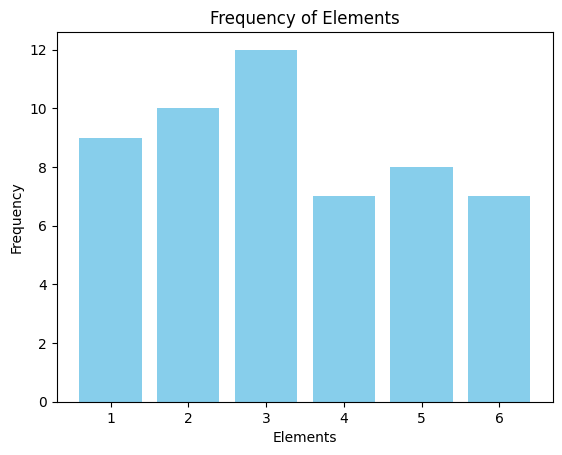

In [20]:

# Sample list
# Create a Counter object
element_counts = Counter(training_labels)

# Prepare data for plotting
labels = list(element_counts.keys())
counts = list(element_counts.values())

# Plot
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Elements')
plt.ylabel('Frequency')
plt.title('Frequency of Elements')
plt.show()

In [19]:
# assert 1 == 2 

In [20]:
# last_loss,  history_epoch["internal_energy_mean"]

tensor(0.1307)


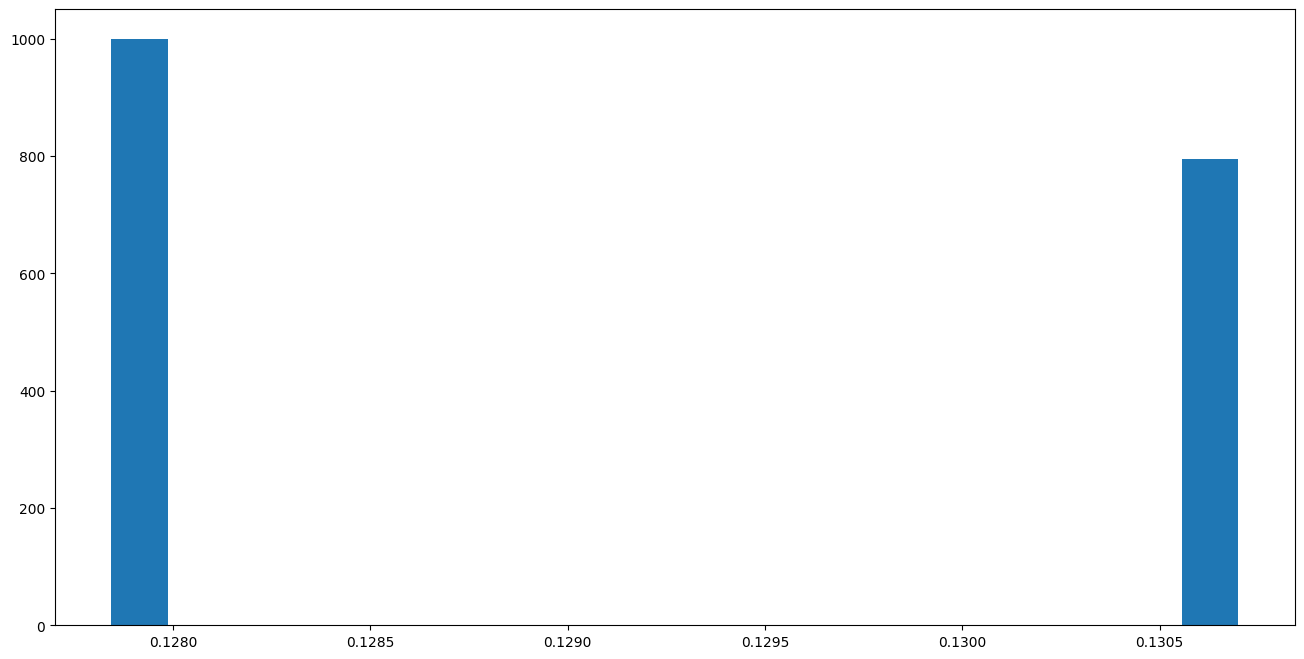

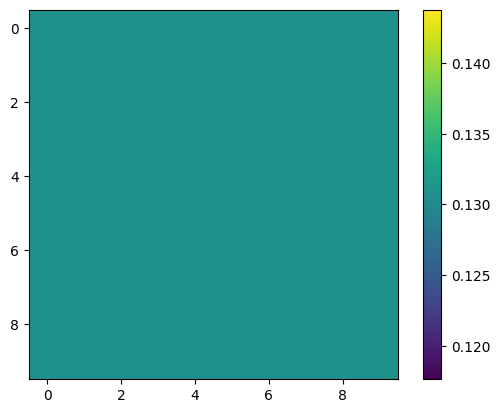

In [21]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:100].reshape(10,10))
    plt.colorbar()
    plt.show()

In [18]:
model.pc_conv1.use_bias

False

In [17]:
if model.pc_conv1.use_bias:
    fig, axs = plt.subplots(figsize=(16,8))

    b = model.pc_conv1.biases.data.cpu().flatten()
    print(b.max())
    plt.hist(b, bins=20)
    plt.show()

    plt.imshow(b[0:2000].reshape(40,50))
    plt.show()

In [23]:
# model_weights_path = "../scr/trained_models/best_models_weights/1/"
# model.save_weights(path=model_weights_path, overide=False)

In [24]:

#     for idx, (batch, clean) in enumerate():
#         torch.cuda.empty_cache()
        
#         try:
#             print("Label:", batch.y, "Input Shape:", batch.x.shape)
#             model.train()
#             # model.pc_conv1.restart_activity()

#             batch = batch.to(device)
#             history_epoch = model.learning(batch)

In [25]:
tmp = iter(train_loader)

batch = next(tmp)

Done for idx 26356
Done for idx 2248


In [26]:
batch[0]

DataBatch(x=[2294, 3, 1], edge_index=[2, 5260142], edge_attr=[5260142], y=[1], batch=[2294], ptr=[2])

In [53]:

# save_path = os.path.join(model_dir, 'parameter_info')
# model.save_weights(path=save_path) 

model.load_weights("../scr/trained_models/best_models_weights/1/", data_eg=batch[0])

Settng weights of self.pc_conv1
loaded weights matrix W
loaded edge index for the graphs
-------------Restarting activity (pred/errors/values)--------------
Done


In [30]:
if model.pc_conv1.use_convergence_monitor:
    model.pc_conv1.convergence_tracker.energy_tracker.energies

    print(model.pc_conv1.convergence_tracker.gradient_tracker.gradients)

[112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672,
 112.76543426513672]

In [ ]:
for idx, (batch, clean) in enumerate(train_loader):
    torch.cuda.empty_cache()
    
    img = batch.x[:,0][0:784].cpu()
    plt.imshow(img.view(28,28))

    break 

In [ ]:
import scipy.sparse as sp

# Extract the edge indices and weights
edge_index = model.pc_conv1.edge_index_single_graph.cpu().numpy()

S2S_    = []
rest_   = []
for weights in model.pc_conv1.w_log:

    # Create a sparse matrix using the edge indices and weights
    W_sparse = sp.coo_matrix((weights.cpu(), (edge_index[0], edge_index[1])), shape=(model.pc_conv1.num_vertices, model.pc_conv1.num_vertices))

    # Convert to dense for detailed visualization (if the graph is not too large)
    W = W_sparse.toarray()

    S2S = W[0:784, 0:784]
    S2S_.append(S2S.max()) #, S2S.min())

    rest = W[784:, 784:]
    rest_.append(rest.max()) # rest.min())


print(np.array(S2S_).mean())
print(np.array(rest_).mean())

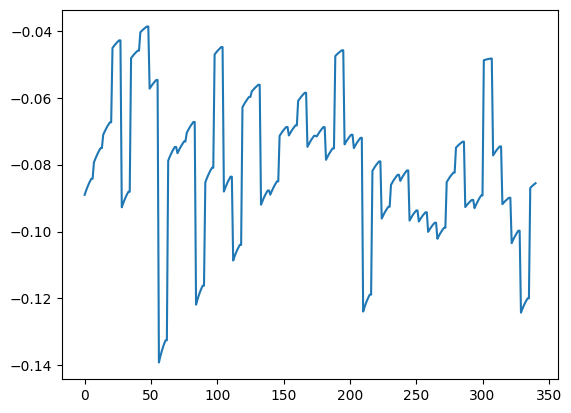

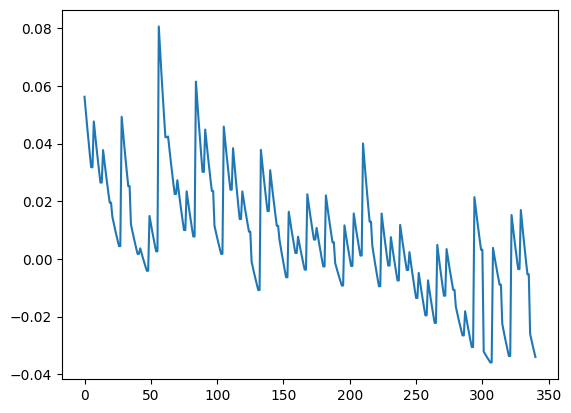

In [28]:
plt.plot(model.pc_conv1.energy_vals["mean_internal_energy_sign"][:])
plt.show()
plt.plot(model.pc_conv1.energy_vals["mean_sensory_energy_sign"][:])
plt.show()

In [ ]:
model.pc_conv1.energy_vals["internal_energy"][:]

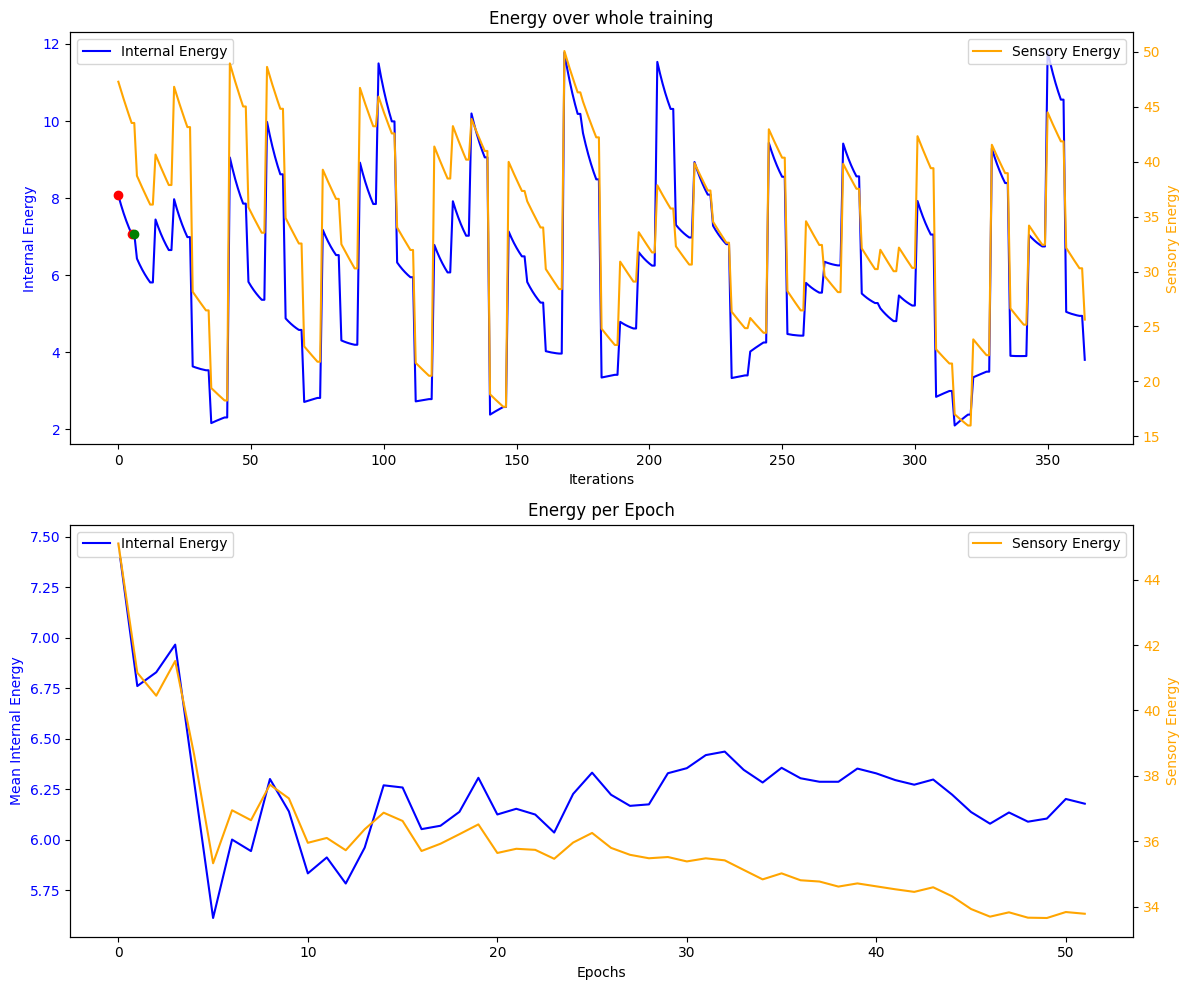

In [22]:
   
plot_energy_during_training(model.pc_conv1.energy_vals["internal_energy"][:], 
                            model.pc_conv1.energy_vals["sensory_energy"][:],
                            history, 
                            point1=(0, model.pc_conv1.energy_vals["internal_energy"][0]),
                            point2=(model.pc_conv1.T, model.pc_conv1.energy_vals["internal_energy"][model.pc_conv1.T]),
                            point3=((model.pc_conv1.T)+1, model.pc_conv1.energy_vals["internal_energy"][(model.pc_conv1.T)+1]),
                            model_dir=None,
                            epoch=epoch)

In [ ]:
plt.hist(model.pc_conv1.weights.cpu().detach().flatten(), bins=10)
plt.show()

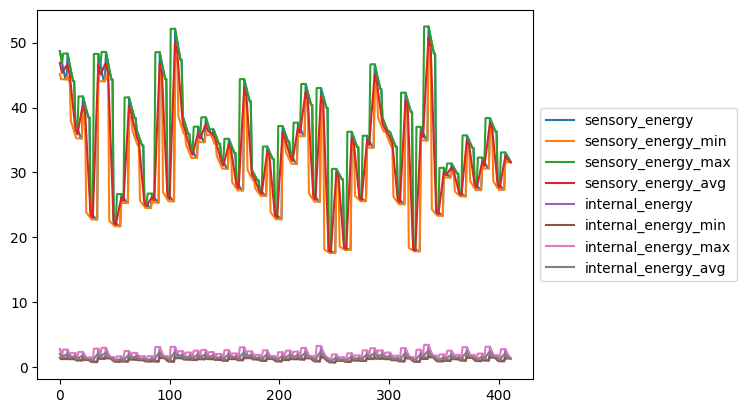

In [21]:
for tmp in ["sensory_energy","internal_energy"]:

    t = model.pc_conv1.energy_vals[tmp]
    plt.plot(t, label=f"{tmp}")

    v_min = []
    v_max = []
    v_avg = []

    for w in range(0, len(t)):

        window = t[w:w+model.pc_conv1.T]
        w_min = min(window)
        w_max = max(window)
        w_avg = sum(window)/len(window)

        # w_mean = 

        v_min.append(w_min)
        v_max.append(w_max)
        v_avg.append(w_avg)

    plt.plot(v_min, label=f"{tmp}_min")
    plt.plot(v_max, label=f"{tmp}_max")
    plt.plot(v_avg, label=f"{tmp}_avg")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

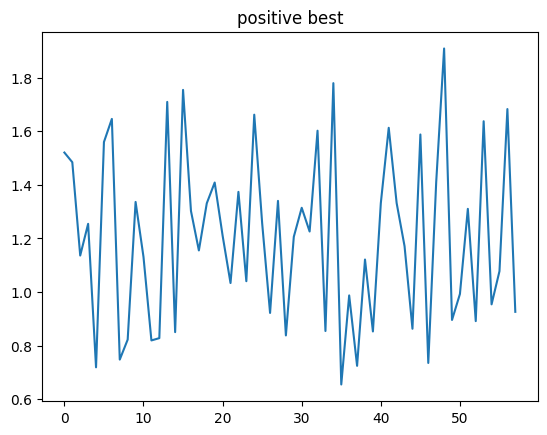

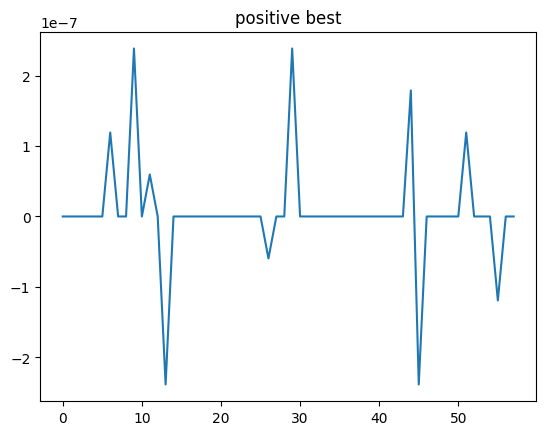

In [22]:
# weight_update_gain energy_drop

plt.plot(model.pc_conv1.energy_vals['energy_drop'])
plt.title("positive best")
plt.show()
plt.plot(model.pc_conv1.energy_vals['weight_update_gain'])
plt.title("positive best")
plt.show()


In [25]:
model.pc_conv1.energy_vals["energy_t0"]

[]

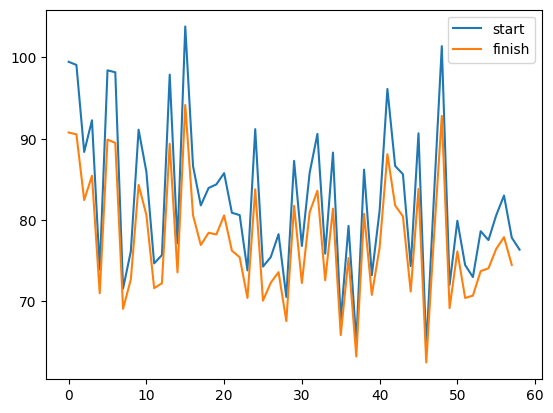

In [23]:
plt.plot(model.pc_conv1.energy_vals['energy_t0'], label="start")
plt.plot(model.pc_conv1.energy_vals['energy_tT'], label="finish")
plt.legend()
plt.show()


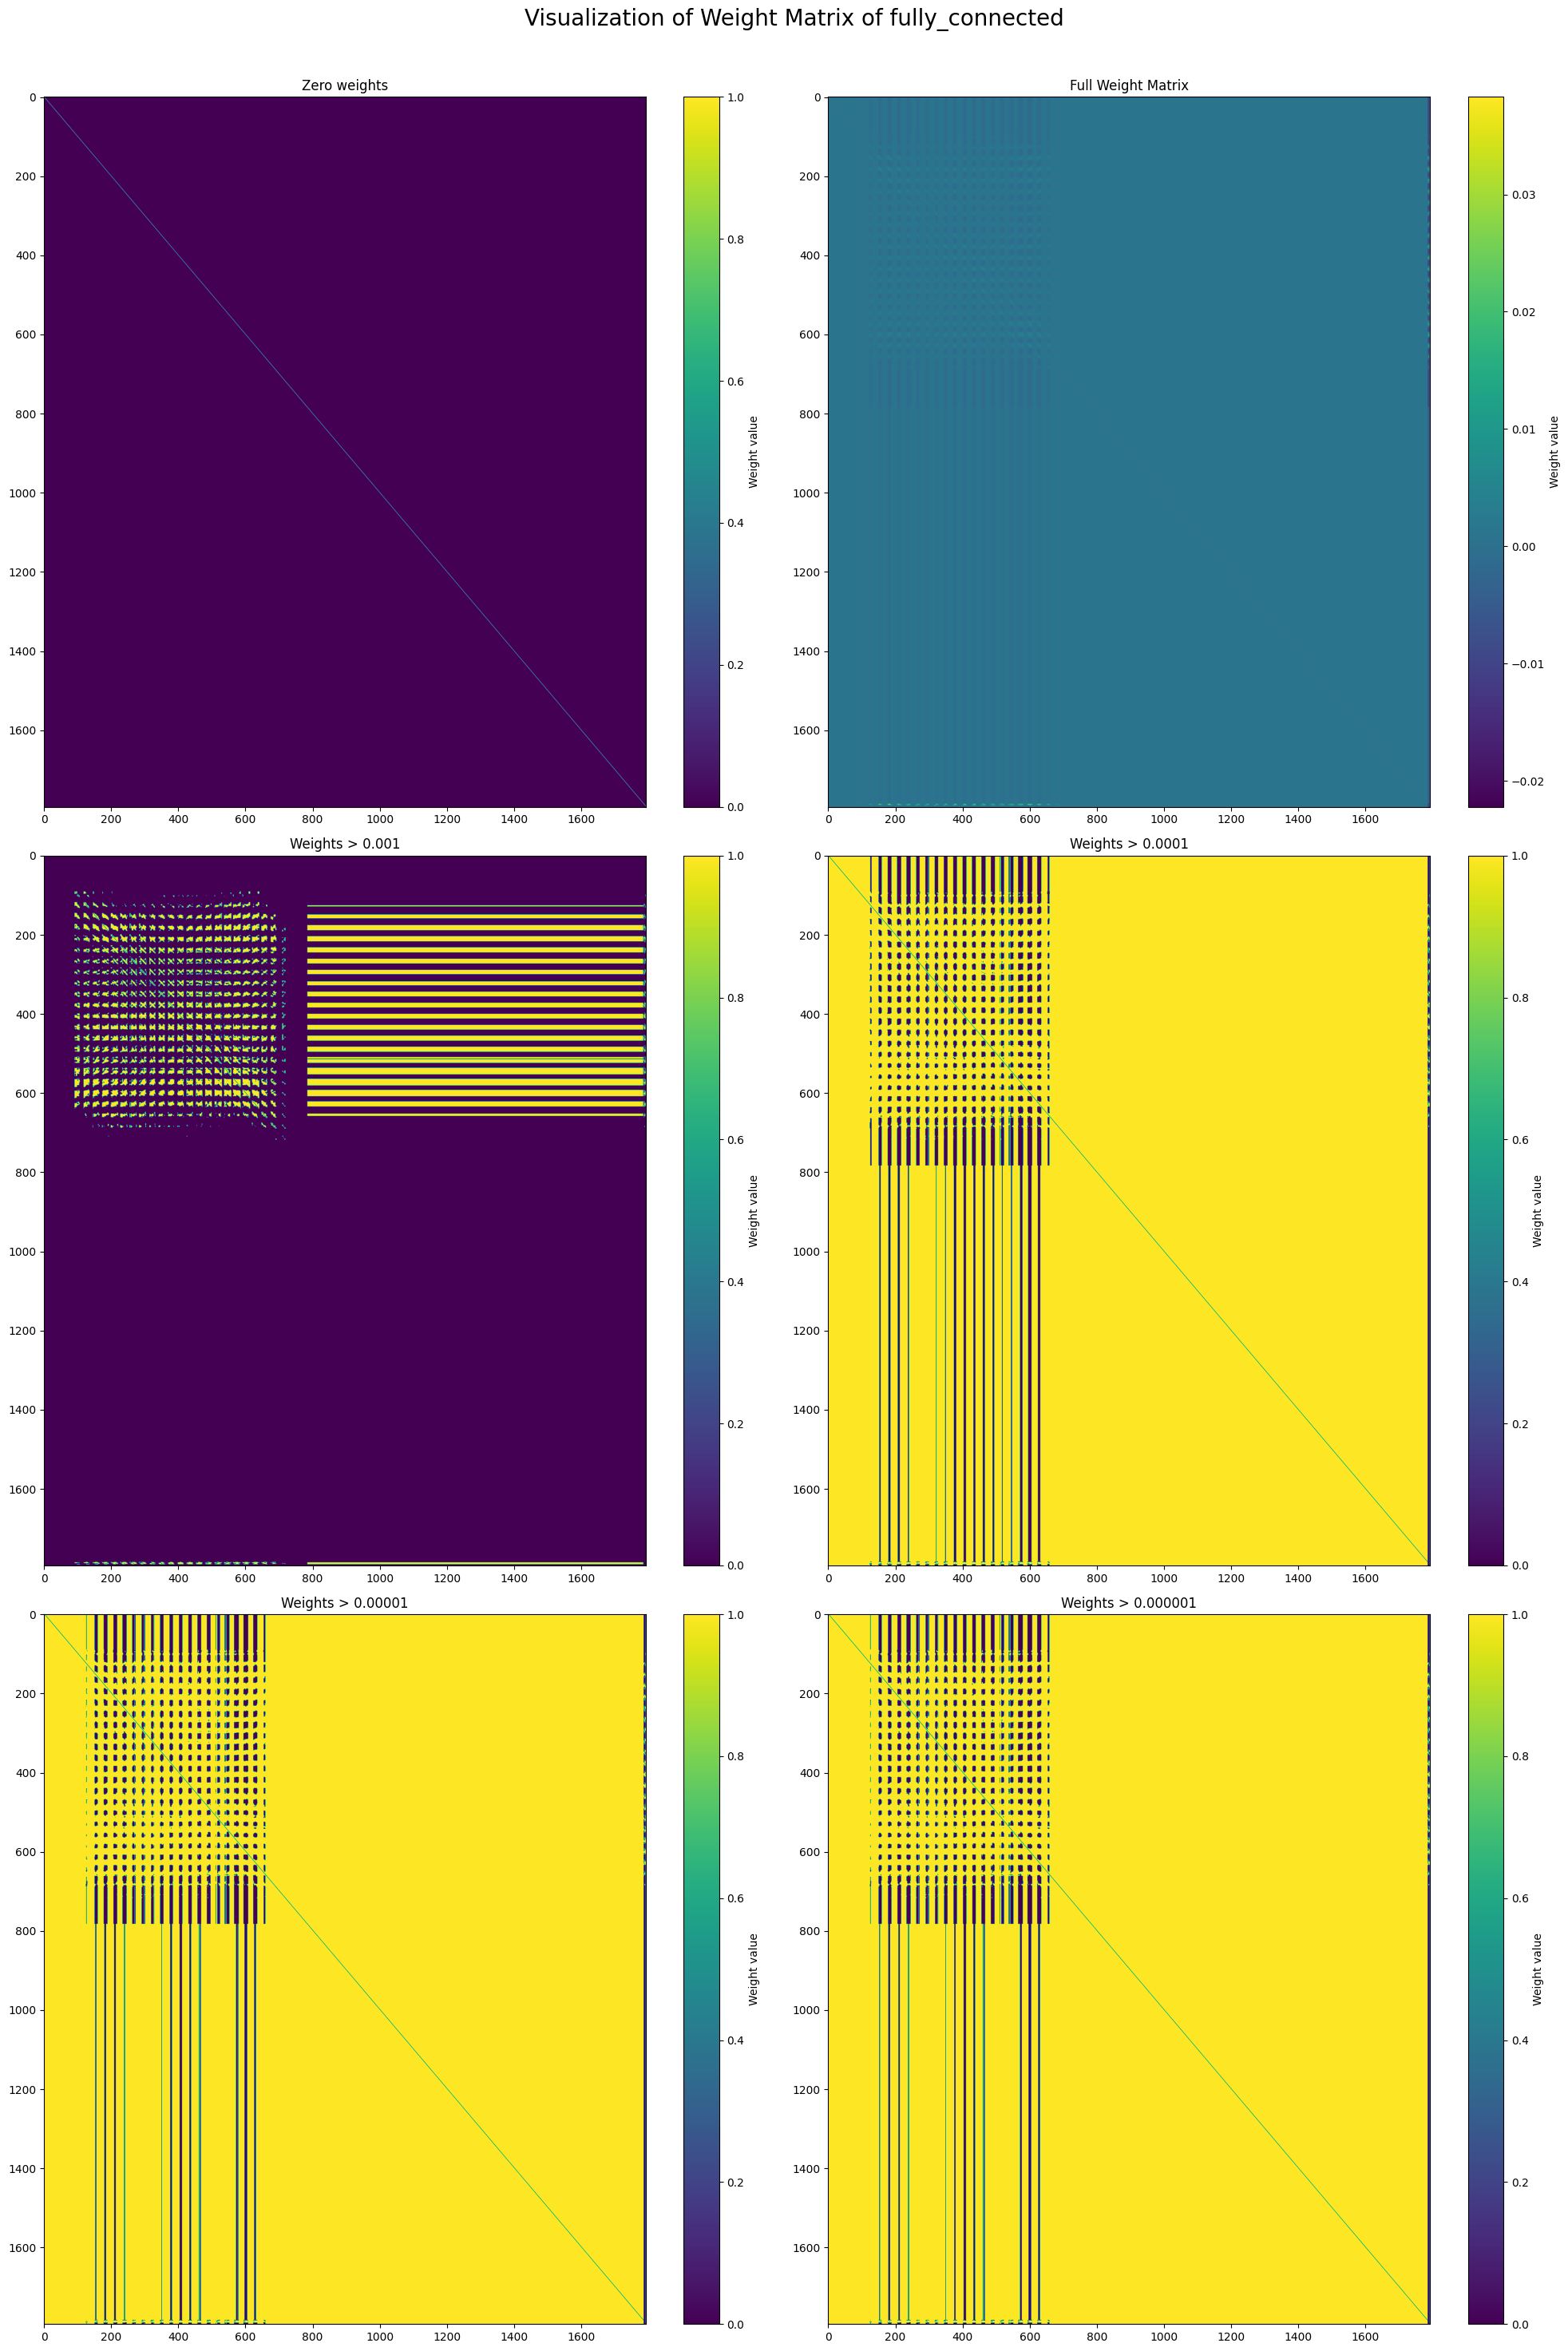

In [23]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
W = plot_model_weights(model, GRAPH_TYPE, model_dir=None)

In [23]:
# Save model weights 
######################################################################################################### 
####                                            Evaluation (setup)                                  #####
#############################################################################################s############ 
 
# device = torch.device('cpu')
from eval_tasks import classification, denoise, occlusion, generation #, reconstruction
model.pc_conv1.batchsize = 1


### Make dataloader for testing where we take all the digits of the number_list we trained on ###
dataset_params_testing = dataset_params.copy()

if "batch_size" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["batch_size"]

if "NUM_INTERNAL_NODES" in dataset_params_testing.keys():
    # remove keys 
    del dataset_params_testing["NUM_INTERNAL_NODES"]

dataset_params_testing["edge_index"] = custom_dataset_train.edge_index

dataset_params_testing["mnist_dataset"] = mnist_testset
dataset_params_testing["N"] = "all"
dataset_params_testing["supervision_label_val"] = dataset_params["supervision_label_val"]



for key in dataset_params_testing:
    print(key, ":\t ", dataset_params_testing[key])


# CustomGraphDataset params
custom_dataset_test = CustomGraphDataset(graph_params, **dataset_params_testing, 
                                        indices=(num_vertices, sensory_indices, internal_indices, supervision_indices)
                                        )
# dataset_params_testing["batch_size"] = 2

test_loader = DataLoader(custom_dataset_test, batch_size=1, shuffle=True, generator=generator_seed)

mnist_dataset :	  Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
supervised_learning :	  True
numbers_list :	  [1, 2, 3, 4, 5, 6]
same_digit :	  False
add_noise :	  False
noise_intensity :	  0.0
N :	  all
edge_index :	  tensor([[  0,   0,   0,  ..., 893, 893, 893],
        [  1,   2,   3,  ..., 890, 891, 892]])
supervision_label_val :	  10
Supervised learning
Taking first n=all digits from each class
-----Done-----
894
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112

In [35]:
# 
# plot_model_weights(model, model_dir=None)

In [36]:
# for idx, (noisy_batch, clean_image) in enumerate(test_loader, start=1):
#     noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape

#     torch.rand(noisy_batch.x[:, 0][model.pc_conv1.internal_indices].shape).shape
#     break

In [24]:
def get_clean_images_by_label(mnist_train, num_images=10):
    """
    Extract num_images clean images for each label (0-9) from mnist_train.
    Returns a dictionary with labels as keys and a list of clean images as values.
    """
    clean_images = {label: [] for label in range(10)}

    for label in range(10):
        # Filter the indices for the current label
        class_indices = [i for i, lbl in enumerate(mnist_train.targets) if lbl == label]
        
        # Get the first num_images clean images for the current label
        clean_images[label] = [mnist_train[i][0].squeeze().numpy() for i in class_indices[:num_images]]

    return clean_images

# Example usage:
clean_images = get_clean_images_by_label(mnist_trainset, num_images=10)

model.trace(values=True, errors=True)


In [ ]:
model.pc_conv1.energy_vals["internal_energy_testing"]

        # self.pc_conv1.energy_vals["internal_energy_testing"] = []
        # self.pc_conv1.energy_vals["sensory_energy_testing"] = []

In [33]:
# model.enable_all_connections()

In [34]:
# # source_nodes = model.pc_conv1.edge_index[0]   # all i's 
# # target_nodes = model.pc_conv1.edge_index[1]   # all j's 

# # # Gather the corresponding errors and f_x values for each edge
# # # print("source_nodes shape", source_nodes.shape)
# # # print("errors shape", errors.shape)
# # # print("f_x shape", f_x.shape)
# # source_errors = model.pc_conv1.values[source_nodes].detach()    # get all e_i's 
# # target_fx = model.pc_conv1.values[target_nodes].detach()   

# # V = source_errors * target_fx

# V_p = V.reshape(model.pc_conv1.batchsize, model.pc_conv1.edge_index_single_graph.size(1)) 
# V_p.shape

In [ ]:
# Example matrices
# matrix_list = [np.random.rand(5, 5) for _ in range(10)]  # Create 10 random 5x5 matrices

# matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["values"] ] 
matrix_list = [i.cpu().detach().squeeze() for i in model.pc_conv1.trace["preds"] ] 

matrix_list = [torch.ger(i, i) for i in matrix_list]

# Create diagonal matrices from each tensor
# matrix_list = [torch.diag(i) for i in matrix_list]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create a figure and axis
fig, ax = plt.subplots()

matrix_list_show = matrix_list[:20]

# Display the first matrix
im = ax.imshow(matrix_list_show[0], cmap='viridis')
cbar = plt.colorbar(im)  # Add the color bar

# Function to update the matrix in each frame
def update(frame):
    im.set_array(matrix_list_show[frame])  # Update the data for the new frame
    return [im]

# Prevent static display of imshow() after the animation
plt.close()

# Create the animation
ani = FuncAnimation(fig, update, frames=len(matrix_list_show), blit=True, interval=500)

# Display the animation in the notebook
HTML(ani.to_jshtml())

In [55]:
import torch

# Create a copy of the current weights
w_copy = model.pc_conv1.weights.clone()

# plt.hist(w_copy.cpu().detach().flatten(), bins=10)
# plt.show()

In [56]:
# Define the threshold
threshold = 0.0001

# Apply the threshold: set weights with absolute values below the threshold to zero
new_w = torch.where(torch.abs(w_copy) < threshold, torch.tensor(0.0, device=w_copy.device), w_copy)

# Assign the thresholded weights back to the model
model.pc_conv1.weights.data = new_w

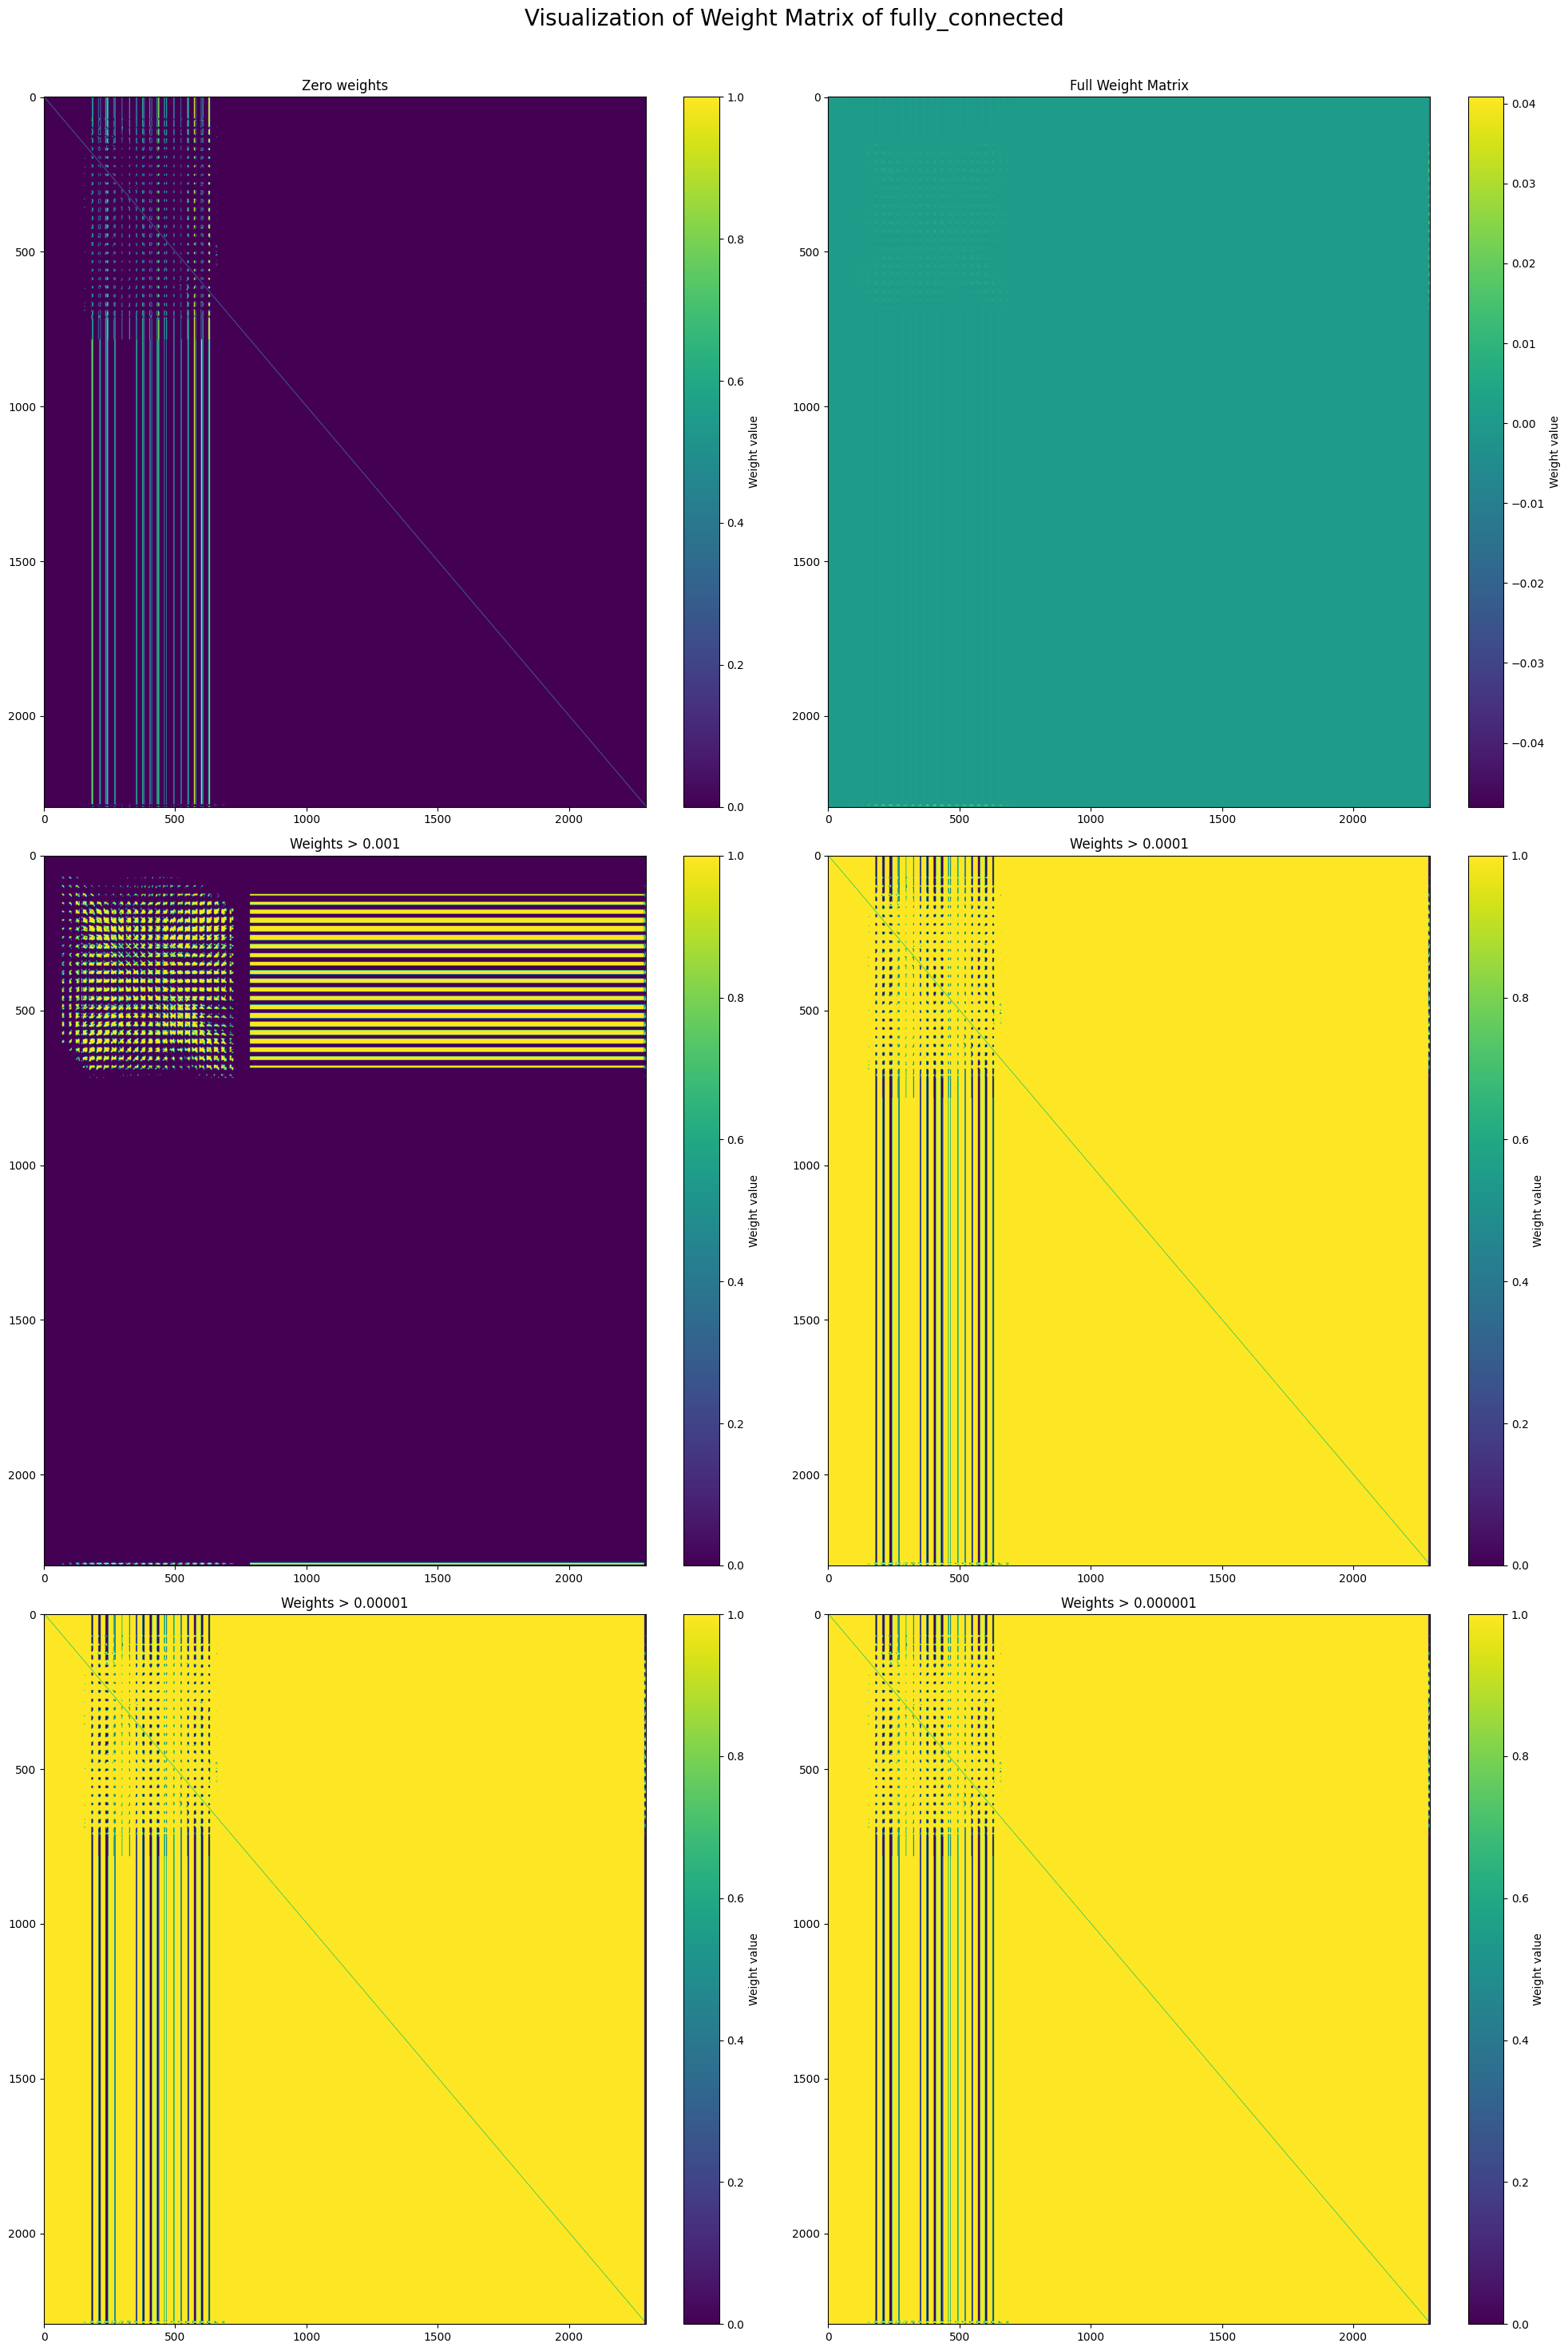

In [57]:
# save_path = os.path.join(model_dir, 'parameter_info/weight_matrix_visualization_epoch_End.png')
W = plot_model_weights(model, GRAPH_TYPE, model_dir=None)

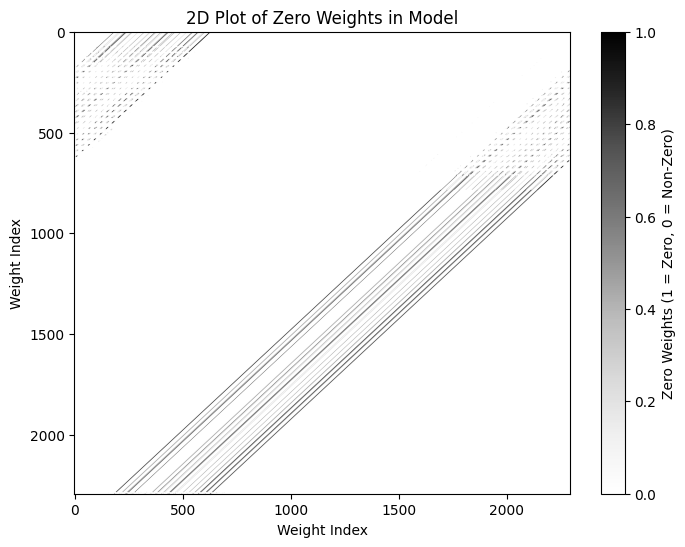

In [58]:
weights = model.pc_conv1.weights.detach().cpu().numpy()

# Identify zero weights and create a mask
zero_weights_mask = (weights == 0).astype(int)  # 1 where weight is zero, 0 elsewhere

# Plot the zero weights as a 2D heatmap
plt.figure(figsize=(8, 6))
plt.imshow(zero_weights_mask.reshape(int(len(weights)**0.5), -1), cmap="Greys", aspect="auto")
plt.colorbar(label="Zero Weights (1 = Zero, 0 = Non-Zero)")
plt.title("2D Plot of Zero Weights in Model")
plt.xlabel("Weight Index")
plt.ylabel("Weight Index")
plt.show()


vertix 894
before after 784 784
before after 100 100
before after 10 10
-------------mode testing--------------
-------------task classification--------------
model.pc_conv1.values.shape torch.Size([894, 1])
AAAAAAAdAAAAA
model.pc_conv1.values.shape torch.Size([894, 1])
CHECK 1  tensor([[ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
No vmin vmax
Done for idx 4987
tensor([2])
torch.Size([894, 3, 1])
CHECK 2  tensor([[ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
CHECK 3  tensor([[ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

Final internal energy (t=T): 0.09319577366113663
Inference completed.
QUery by condition or query by init
Predic. at T, no vmin vmax 0.7795969 -0.3629341
Denoised val 0.99607843 0.0
tensor([0.1513, 0.5894, 2.3478, 0.8726, 1.1576, 0.9324, 1.3720, 0.1513, 0.1513,
        0.1513], device='cuda:0')
tensor([0.1513, 0.5894, 2.3478, 0.8726, 1.1576, 0.9324, 1.3720, 0.1513, 0.1513,
        0.1513], device='cuda:0')
tensor([[0.1513],
        [0.5894],
        [2.3478],
        [0.8726],
        [1.1576],
        [0.9324],
        [1.3720],
        [0.1513],
        [0.1513],
        [0.1513]], device='cuda:0')
tensor([0.0401, 0.0622, 0.3611, 0.0826, 0.1098, 0.0877, 0.1361, 0.0401, 0.0401,
        0.0401], device='cuda:0')
tensor(2)


KeyError: 'num_wandb_img_log'

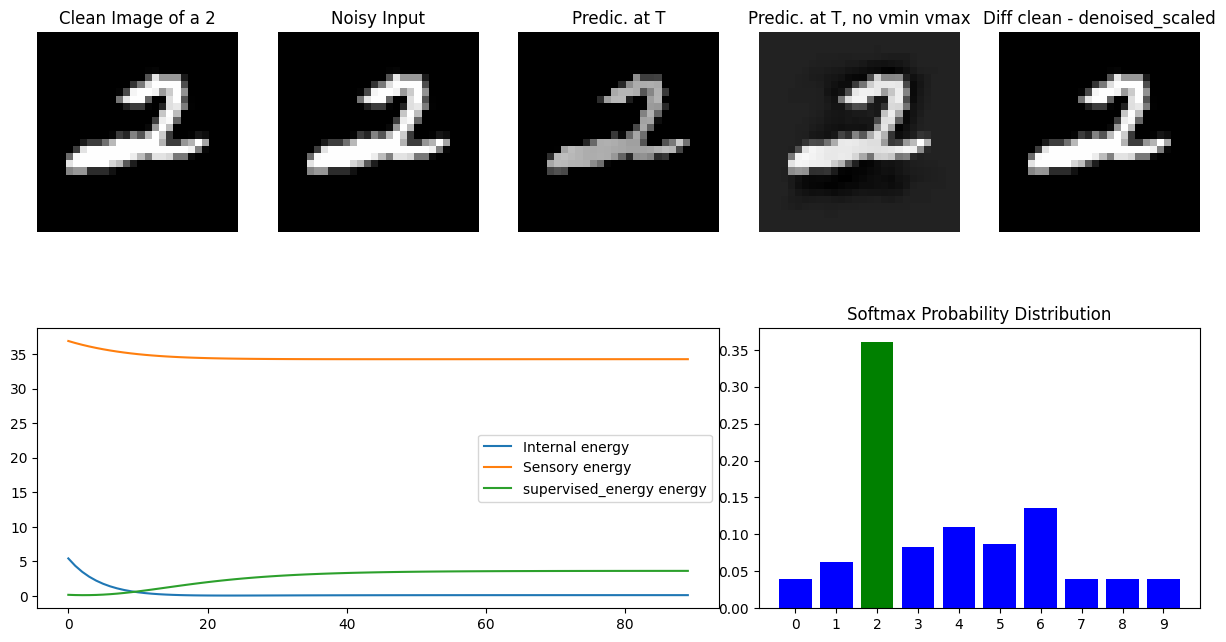

In [26]:

model.pc_conv1.batchsize = 1

test_params = {
    "model_dir": model_dir,
    "T":90,
    "supervised_learning":False, 
    "num_samples": 1,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
y_true, y_pred, accuracy_mean = classification(test_loader, model, test_params)

IMPORTANT SEE OLD OCCLUSION func; 
-------------Restarting activity (pred/errors/values)--------------
vertix 894
before after 784 784
before after 100 100
before after 10 10
-------------mode testing--------------
-------------task generation--------------
Occulusion model.pc_conv1.values.shape torch.Size([894, 1])
-------------Restarting activity (pred/errors/values)--------------
No vmin vmax
Done for idx 1044
tensor([1])
labels model tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
aaa testing
CHECK tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')


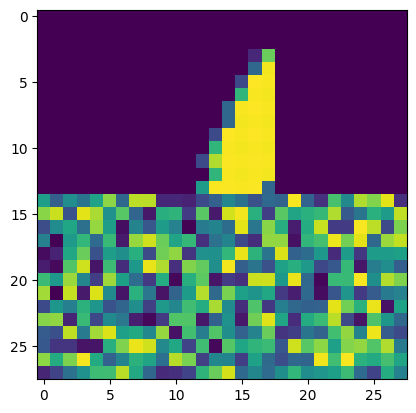

Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS generation
Pass
-------------Restarting activity (pred/errors/values)--------------
Aaaa torch.Size([894, 3, 1])
Initial internal energy (t=0): 6.899636745452881


Final internal energy (t=T): 0.0018503142055124044
Inference completed.
QUery by condition or query by init
CHECK tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Predic. at T, no vmin vmax 0.8153737 -0.21935898
Denoised val 1.0 0.0


IndexError: list index out of range

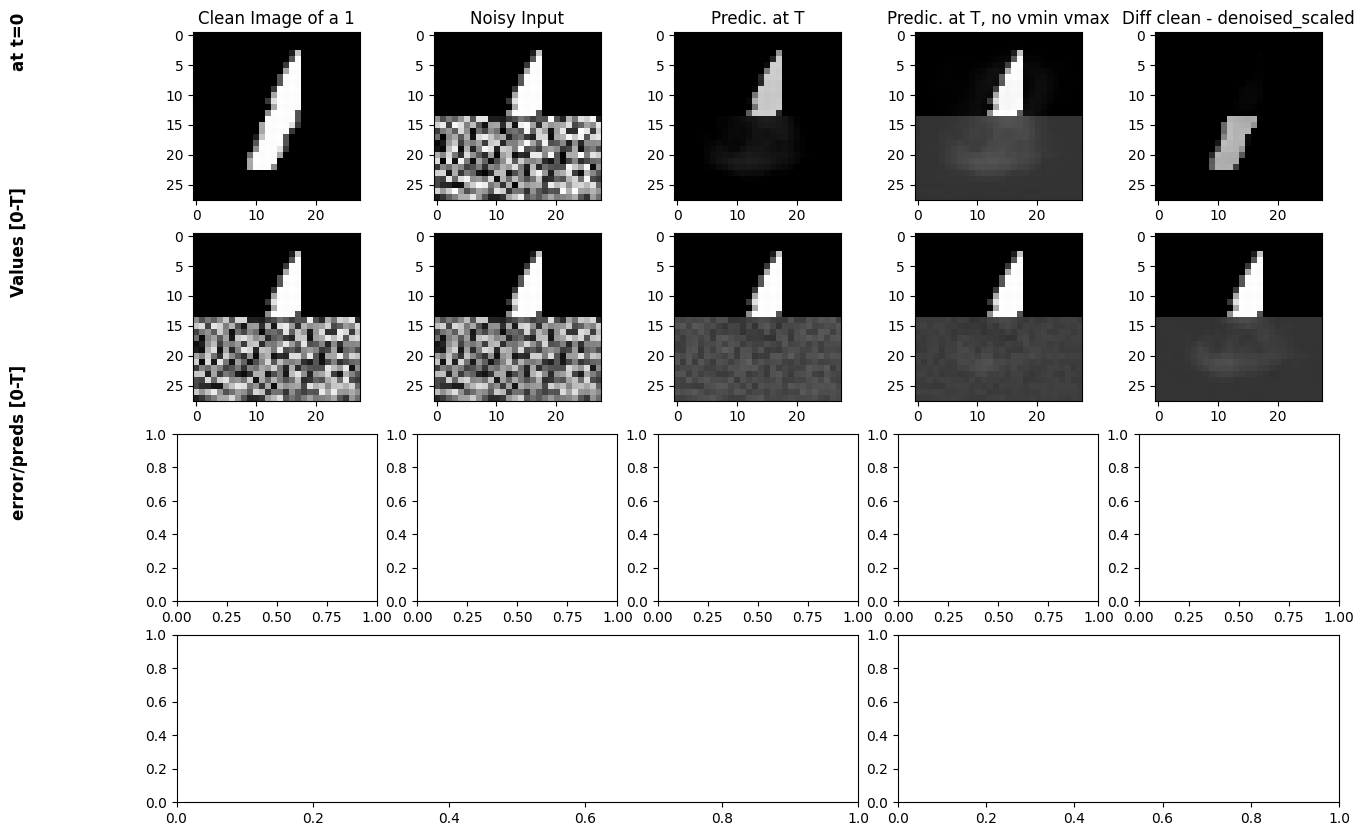

In [27]:


model.pc_conv1.batchsize = 1

######################################################################################################### 
####                                            Evaluation (tasks)                                  #####
######################################################################################################### 
 
test_params = {
    "model_dir": None,
    "T": 50,
    "supervised_learning":False, 
    "num_samples": 1,
    "add_sens_noise": True,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1 
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_occ = occlusion(test_loader, model, test_params)

In [ ]:
MSE_values_occ

In [ ]:


######################################################################################################### 

######################################################################################################### 

test_params["add_sens_noise"] = True
MSE_values_occ_noise = occlusion(test_loader, model, test_params)

test_params = {
    "model_dir": model_dir,
    "T": 300,
    "supervised_learning":True, 
    "num_samples": 6,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]

MSE_values_denoise_sup = denoise(test_loader, model, test_params)

test_params["supervised_learning"] = False
MSE_values_denoise = denoise(test_loader, model, test_params)
                            
# MSE_values = denoise(test_loader, model, supervised_learning=True)
# print("MSE_values", MSE_values)
######################################################################################################### 



# # MSE_values = denoise(test_loader, model, supervised_learning=True)
# # print("MSE_values", MSE_values)


# print("accuracy_mean", accuracy_mean)

# print("model_dir", model_dir)

# # write a text file with these 


# # Open the file in write mode
# with open(model_dir + "eval/eval_scores.txt", 'w') as file:
#     # Write each list to the file

#     file.write("MSE_values_denoise_sup:\n")
#     file.write(", ".join(map(str, MSE_values_denoise_sup)) + "\n\n")

#     file.write("MSE_values_denoise:\n")
#     file.write(", ".join(map(str, MSE_values_denoise)) + "\n\n")
    
#     file.write("MSE_values_occ_noise:\n")
#     file.write(", ".join(map(str, MSE_values_occ_noise)) + "\n\n")
    
#     file.write("MSE_values_occ:\n")
#     file.write(", ".join(map(str, MSE_values_occ)) + "\n\n")

#     file.write("accuracy_mean:\n")
#     file.write("y_true: " + ", ".join(map(str, y_true)) + "\n")
#     file.write("y_pred: " + ", ".join(map(str, y_pred)) + "\n")
    
#     file.write(str(accuracy_mean) + "\n\n")


# from datetime import datetime
# # Get the current date and time
# current_datetime = datetime.now()
# # Print the current date and time
# print("Current date and time:", current_datetime)



# wandb.log({"accuracy_mean": accuracy_mean})
# # wandb.log({"energy_sensory": energy["sensory_energy"]})






# wandb.finish()

In [15]:
# model.Disable_connection(from_indices=sensory_indices, 
#                          to_indices=supervision_indices)

In [ ]:
# model.enable_all_connections()

In [ ]:
plt.imshow(model.pc_conv1.trace['preds'][0][0:784].view(28,28).cpu())
plt.show()

In [ ]:
tr = model.pc_conv1.trace["values"]
len(tr)

In [ ]:
model.pc_conv1.mode

In [28]:
a = model.pc_conv1.weights.cpu().detach()

print(a.min(), a.max(), a.mean())

tensor(-0.0180) tensor(0.0381) tensor(0.0010)


-------------Restarting activity (pred/errors/values)--------------
-------------Restarting activity (pred/errors/values)--------------
vertix 894
before after 784 784
before after 100 100
before after 10 10
-------------mode testing--------------
-------------task generation--------------
model.pc_conv1.values.shape torch.Size([894, 1])
-------------Restarting activity (pred/errors/values)--------------
No vmin vmax
Done for idx 3466
tensor([5])
torch.Size([894, 3, 1])
omitting setting sensory nodes
labels before torch.Size([10]) tensor([0.0000, 0.8839, 0.0000, 0.0000, 0.1016, 0.0000, 0.0000, 0.2548, 0.0000,
        0.0000], device='cuda:0')
labels after tensor([0.0000, 0.8839, 0.0000, 0.0000, 0.1016, 0.0000, 0.0000, 0.2548, 0.0000,
        0.0000], device='cuda:0')
tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
labels model tensor([[ 0.],
        [ 0.],
        [ 0

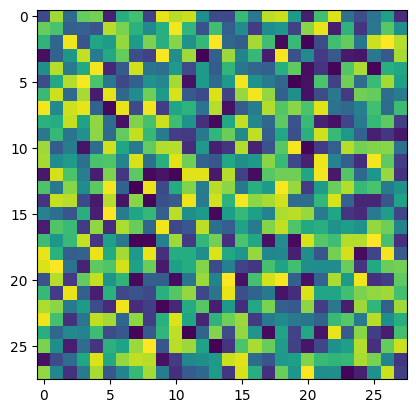

Random init values of all internal nodes
----------------reconstruction-----------------
TASK IS generation
Pass
-------------Restarting activity (pred/errors/values)--------------
Aaaa torch.Size([894, 3, 1])
Initial internal energy (t=0): 4.449041366577148


Final internal energy (t=T): 0.5296672582626343
Inference completed.
QUery by condition or query by init
CHECK tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
Predic. at T, no vmin vmax 0.28359878 0.075763464
Denoised val 0.6020073 -0.007950424
generation_task_5.png
CHECK tensor([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [10.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], device='cuda:0')
ssim_values [0.2980463235123788]
mse_values [0.069994465]
ssim_values [0.2980463235123788, 0.05803544724080743]
mse_values [0.069994465, 0.09346025]
ssim_values [0.2980463235123788, 0.05803544724080743, 0.20394140470604596]
mse_values [0.069994465, 0.09346025, 0.06977785]
ssim_values [0.2980463235123788, 0.05803544724080743, 0.20394140470604596, 0.22544641038433658]
mse_values [0.069994465, 0.09346025, 0.06977785, 0.07601151]
ssim_valu

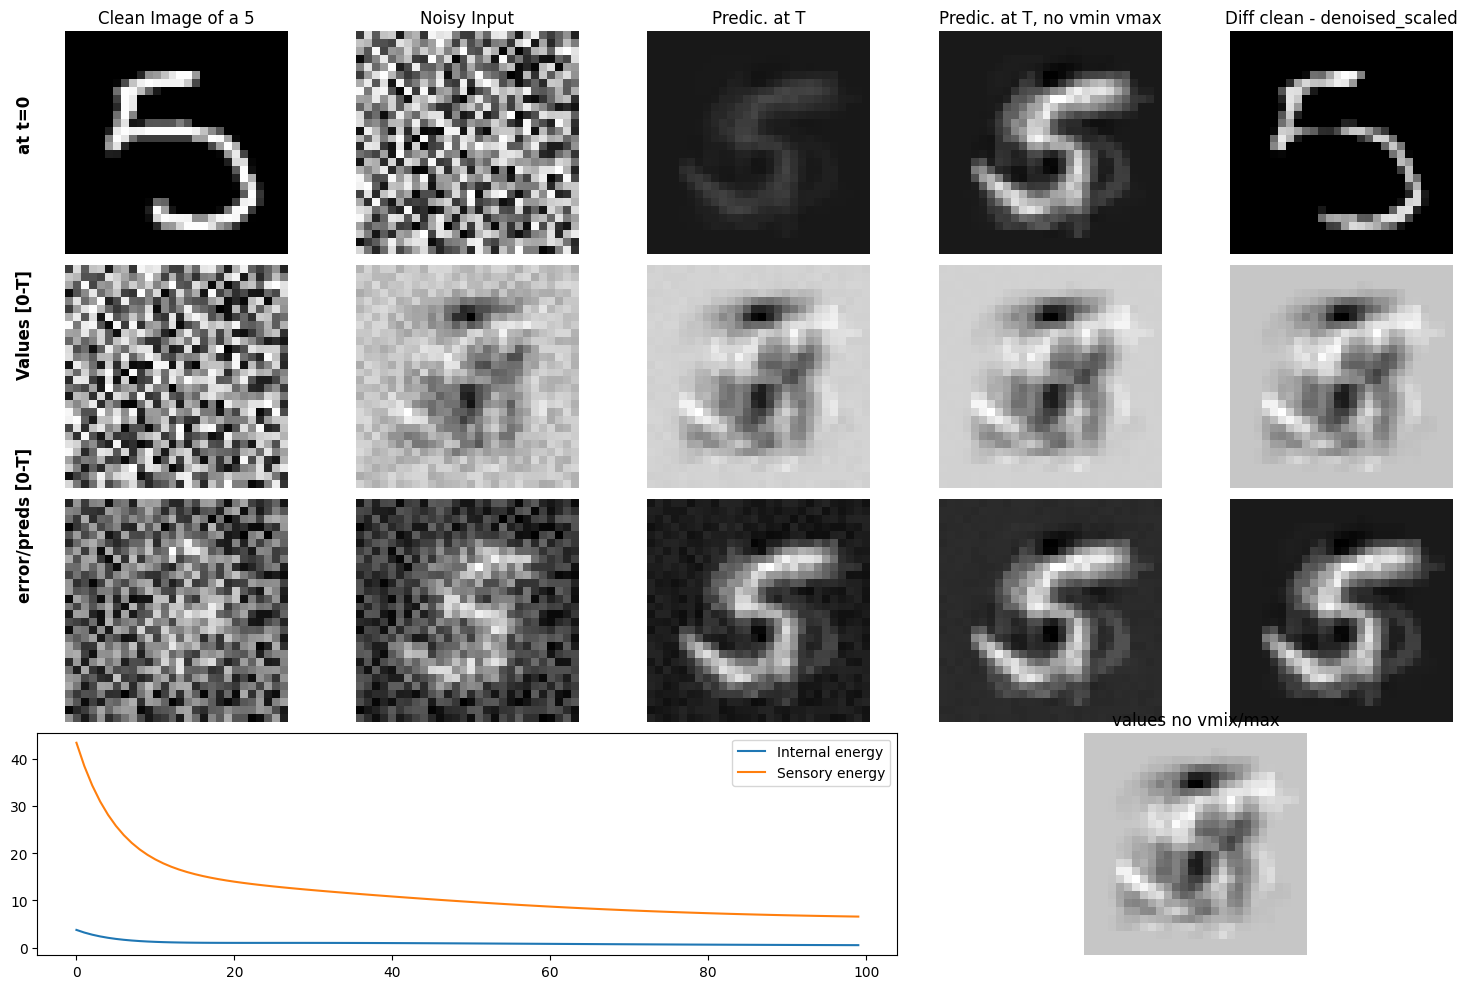

In [29]:
test_params = {
    "model_dir": model_dir,
    "T":100,
    "supervised_learning":True, 
    "num_samples": 1,
    "num_wandb_img_log":0,
}

# model.pc_conv1.lr_values = 0.1
# model.pc_conv1.lr_values = model_params["lr_params"][0]
model.pc_conv1.trace_activity_values = True 
model.pc_conv1.trace_activity_preds = True 

model.pc_conv1.restart_activity()

avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max = generation(test_loader, model, test_params, clean_images, verbose=1)
                            

In [ ]:
len(model.pc_conv1.trace["values"]), len(model.pc_conv1.trace["preds"])

In [ ]:
avg_SSIM_mean, avg_SSIM_max, avg_MSE_mean, avg_MSE_max

In [ ]:
a = model.pc_conv1.trace["values"]

a[0] == a[10]

In [ ]:
tr = model.pc_conv1.trace["values"]
print(len(tr))
# for img in tr:
#     plt.imshow(img[0:784].view(28,28).cpu().detach().numpy())
#     plt.show()

In [ ]:
# len(model.pc_conv1.trace["values"])
plt.imshow(model.pc_conv1.trace["values"][0][0:784].view(28,28).cpu())

In [50]:
import math 
# Define the range for logarithmic initialization
log_min = 1e-4  # Minimum value in the range
log_max = 1e-1  # Maximum value in the range
# num_weights = self.edge_index_single_graph.size(1)  # Number of weights to initialize
num_weights = 100  # Number of weights to initialize

# Initialize weights logarithmically between log_min and log_max
log_weights = torch.logspace(math.log10(log_min), math.log10(log_max), steps=num_weights)

# # Simulate a lognormal distribution for synaptic weights based on the description
# mu, sigma = 0, 1  # Mean and standard deviation for lognormal distribution
# weights = np.random.lognormal(mu, sigma, 1000)

# Using batch size, we want the same edge weights at each subgraph of the batch
# weights = torch.nn.Parameter(log_weights)
weights = log_weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the histogram of the weights
plt.figure(figsize=(8, 6))
plt.hist(weights, bins=50, density=True, alpha=0.75, color='b')
plt.title('Lognormal Distribution of Synaptic Weights')
plt.xlabel('Weight')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()